# Emergency Response System: Intelligent Crisis Management: Unlocking Enterprise Data with MongoDB Vector Search, LangChain, and LangGraph

-------------


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/partners/langchain/agentic_knowledge_discovery_notebook.ipynb)

[![AI Learning Hub](https://img.shields.io/badge/AI%20Learning%20Hub-Click%20Here-blue)](https://www.mongodb.com/resources/use-cases/artificial-intelligence?utm_campaign=ai_learning_hub&utm_source=github&utm_medium=referral)

## **Use Case Overview**

In today's complex technical environment, organizations face critical incidents—ranging from network outages and security breaches to infrastructure failures and service disruptions. When these crises occur, teams must rapidly mobilize the right expertise, access relevant knowledge resources, and coordinate response efforts under significant time pressure.

Imagine:
- a critical 5G network outage affecting multiple metropolitan areas,
- a data center hardware failure impacting enterprise customers,
- or a security breach requiring immediate containment.

Each crisis demands rapid response spanning multiple technical domains, requiring organizations to quickly assemble the right experts, access relevant procedures, and coordinate complex actions—all while business-critical services remain offline.

This solution transforms Emergency Response Management by:

* **Accelerating crisis detection**: Automatically parsing incident reports to extract critical parameters, affected systems, and required skill sets.
* **Assembling optimal response teams**: Identifying available experts with the precise skills needed for each unique crisis situation.
* **Mobilizing knowledge resources**: Retrieving relevant technical procedures, best practices, and previous incident documentation.
* **Orchestrating coordinated response**: Generating comprehensive response plans with prioritized action items, team assignments, and communication protocols.

Built on `MongoDB Atlas Vector Search` for high-performance semantic search and document retrieval, `LangChain` and `LangGraph` for agentic workflow orchestration, this approach delivers an intelligent emergency response system that dramatically reduces incident resolution time and business impact.


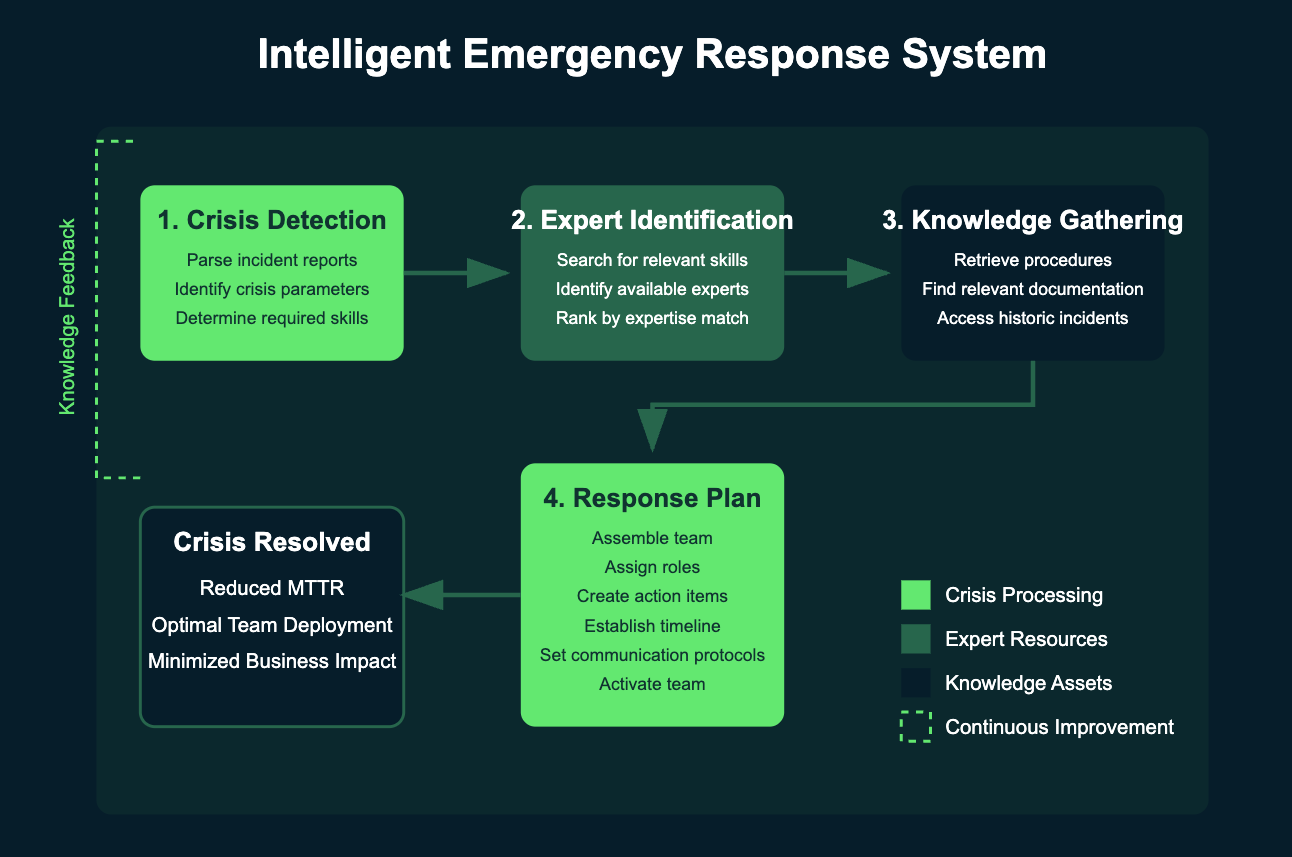

**Key Components**

1. Crisis Detection: Analyzes unstructured incident reports to extract structured data about the crisis type, severity, affected systems, and required expertise.
2. Expert Identification: Searches employee records using semantic matching to identify personnel with crisis-relevant skills and availability.
3. Knowledge Resource Gathering: Retrieves technical documentation, recovery procedures, and best practices specifically relevant to the current crisis.
4. Response Plan Generation: Creates comprehensive response plans with team assignments, prioritized action items, communication protocols, and estimated resolution timelines.

**Business Impact**

* Reduced Average Time to Resolution: Accelerates response time by automating the most time-consuming aspects of crisis management.
* Optimal Team Composition: Ensures the most qualified experts are engaged based on real-time availability and precise skill matching.
* Enhanced Decision Support: Provides response teams with only the most relevant knowledge resources and procedures.
* Improved Stakeholder Communication: Generates structured briefings and updates for both technical teams and business stakeholders.

This intelligent system transforms crisis management from a reactive, often chaotic process into a structured, data-driven workflow that minimizes business impact and accelerates service restoration.


**Cross-Industry Applications**
This emergency response architecture can be readily adapted to various industries:

**1. Healthcare**

- Mobilizing specialized medical teams for rare conditions or mass casualty events
- Coordinating expertise during disease outbreaks or public health emergencies

**2. Financial Services**

- Assembling fraud response teams for complex financial incidents
- Coordinating technical and business experts during trading system failures

**3. Energy and Utilities**

- Mobilizing technical teams during power grid failures or outages
- Assembling environmental specialists during contamination events

**4. Manufacturing**

- Coordinating experts to minimize downtime on critical production equipment
- Assembling cross-functional teams for supply chain or quality control crises

**5. Transportation**

- Mobilizing aviation or maritime experts during system failures or safety incidents
- Coordinating response teams for logistics network disruptions

**6. Government**

- Assembling emergency management teams during natural disasters
- Mobilizing technical expertise for infrastructure failures or cybersecurity incidents

**Objective**:

Enable enterprise users to query and explore organizational knowledge across FAQs, project details, and employee expertise in natural language.

**Key Benefits:**

- Reduced time-to-insight: Semantic search surfaces relevant results even when keywords differ.

- Contextual reasoning: Agents chain multi-step queries (e.g., “Which engineer led Project P123?”).

- Scalable architecture: Easily extend to new data sources (Confluence, emails, design documents).

**Key Components:**

- MongoDB Atlas Vector Search: Dense vector indexing for semantic relevance.

- Voyage AI: State of the art embedding models and rerankers

- LangChain: Embedding pipelines and workflow management.

- LangGraph: Agentic, graph-driven decision making for complex queries.



In [1]:
! pip install -qU openai pymongo voyageai langchain_voyageai langchain_openai langchain-mongodb langgraph-checkpoint-mongodb langchain-core langgraph

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
letta 0.6.20 requires numpy<2.0.0,>=1.26.2, but you have numpy 2.3.2 which is incompatible.
letta 0.6.20 requires pydantic<2.10.0,>=2.7.4, but you have pydantic 2.11.7 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import getpass
import os


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

In [3]:
# Set your OpenAI API Key
# TODO: Place a link on where openai api key can be obtained
set_env_securely("OPENAI_API_KEY", "Enter your OPENAI API KEY: ")

## Part 0: Synthetic Data Creation

In [4]:
import json
from typing import Any, List, Optional

from pydantic import BaseModel, Field


# Define Pydantic data models for datasets
class FAQ(BaseModel):
    faq_id: str = Field(..., description="Unique FAQ identifier")
    question: str = Field(..., description="FAQ question text")
    answer: str = Field(..., description="FAQ answer text")
    tags: List[str] = Field(default_factory=list, description="Related tags")


class Project(BaseModel):
    project_id: str = Field(..., description="Unique project identifier")
    name: str = Field(..., description="Project name")
    description: str = Field(..., description="Detailed project description")
    status: str = Field(..., description="Current project status")
    start_date: str = Field(..., description="ISO format start date")
    end_date: str = Field(..., description="ISO format end date")

    # Team information
    project_manager: str = Field(..., description="Employee ID of project manager")
    team_members: List[str] = Field(..., description="List of employee IDs")

    # Technical details
    technologies: List[str] = Field(..., description="Technology stack")
    skills_required: List[str] = Field(..., description="Required skills")

    # Project relationships
    dependencies: List[str] = Field(
        default_factory=list, description="Dependent project IDs"
    )
    related_projects: List[str] = Field(
        default_factory=list, description="Related project IDs"
    )


class Employee(BaseModel):
    emp_id: str = Field(..., description="Unique employee identifier")
    name: str = Field(..., description="Employee full name")
    role: str = Field(..., description="Employee role/title")
    department: str = Field(..., description="Department name")
    skills: List[str] = Field(default_factory=list, description="List of skills")
    bio: Optional[str] = Field(None, description="Short professional biography")
    manager: Optional[str] = Field(None, description="Employee ID of manager")
    start_date: str = Field(..., description="ISO format start date")
    end_date: str = Field(..., description="ISO format end date")

    # Project relationships
    current_projects: List[str] = Field(
        default_factory=list, description="Current project IDs"
    )
    past_projects: List[str] = Field(
        default_factory=list, description="Past project IDs"
    )

    # Team relationships
    mentors: List[str] = Field(
        default_factory=list, description="Employee IDs of mentors"
    )
    mentees: List[str] = Field(
        default_factory=list, description="Employee IDs of mentees"
    )
    frequent_collaborators: List[str] = Field(
        default_factory=list, description="Frequent collaborators"
    )


class KnowledgeAsset(BaseModel):
    asset_id: str = Field(..., description="Unique knowledge asset ID")
    title: str = Field(..., description="Title of the knowledge asset")
    content: str = Field(..., description="Content or description")
    type: str = Field(..., description="Type (documentation, best_practice, solution)")
    author: str = Field(..., description="Employee ID of author")
    creation_date: str = Field(..., description="ISO creation date")
    tags: List[str] = Field(default_factory=list, description="Tags for categorization")
    related_projects: List[str] = Field(
        default_factory=list, description="Related project IDs"
    )
    related_employees: List[str] = Field(
        default_factory=list, description="Related employee IDs"
    )


# Mapping from dataset type to Pydantic model
model_map = {
    "faqs": FAQ,
    "projects": Project,
    "employees": Employee,
    "knowledge_assets": KnowledgeAsset,
}

In [5]:
class DatasetReference:
    """Track generated IDs for cross-referencing between datasets"""

    def __init__(self):
        self.employee_ids = set()
        self.project_ids = set()
        self.faq_ids = set()
        self.knowledge_asset_ids = set()

In [6]:
data_refs = DatasetReference()

In [7]:
from openai import OpenAI

openai_client = OpenAI()


def generate_synthetic_data_with_refs(
    dataset_type: str, instructions: str, entry: int, data_refs
) -> BaseModel:
    """Generate synthetic data with valid references to other datasets"""

    if dataset_type not in model_map:
        raise ValueError(f"Unsupported dataset type: {dataset_type}")

    selected_model = model_map[dataset_type]
    current_id = f"{dataset_type}-{entry}"

    # Build reference context based on dataset type
    if dataset_type == "employees":
        data_refs.employee_ids.add(current_id)
        reference_context = f"""
        Valid reference IDs:
        - Employee IDs: {list(data_refs.employee_ids) if data_refs.employee_ids else 'None yet'}
        - Project IDs: {list(data_refs.project_ids) if data_refs.project_ids else 'None yet'}

        Instructions:
        - For mentors/mentees: Use existing employee IDs from the list above
        - For current_projects/past_projects: Use existing project IDs
        - Leave lists empty if no valid IDs are available yet
        """

    elif dataset_type == "projects":
        data_refs.project_ids.add(current_id)
        reference_context = f"""
        Valid reference IDs:
        - Employee IDs: {list(data_refs.employee_ids)}
        - Project IDs: {list(data_refs.project_ids) if data_refs.project_ids else 'None yet'}

        Instructions:
        - For team_members/project_manager: Use employee IDs from the list above
        - For dependencies/related_projects: Use project IDs (leave empty for first few projects)
        - Ensure all referenced IDs exist in the lists above
        """

    elif dataset_type == "knowledge_assets":
        data_refs.knowledge_asset_ids.add(current_id)
        reference_context = f"""
        Valid reference IDs:
        - Employee IDs: {list(data_refs.employee_ids)}
        - Project IDs: {list(data_refs.project_ids)}

        Instructions:
        - For author: Use one employee ID from the list above
        - For related_projects: Use valid project IDs
        - For related_employees: Use valid employee IDs
        """

    else:  # FAQs don't need references
        reference_context = "This entity type doesn't need ID references."

    # Enhanced instructions with reference context
    full_instructions = f"""
    {instructions}

    REFERENCE CONTEXT:
    {reference_context}

    IMPORTANT: Only use IDs from the valid reference lists above.
    """

    # Generate the data
    response = openai_client.responses.parse(
        model="gpt-4.1",
        input=f"Generate a synthetic {dataset_type} record with the id '{current_id}'. {full_instructions}",
        text_format=selected_model,
    )

    return response.output_parsed

In [8]:
from tqdm import tqdm


def generate_all_synthetic_data():
    """Generate all synthetic datasets with proper ID references"""

    # Clear previous references
    global data_refs
    data_refs = DatasetReference()

    all_datasets = {}

    # 1. Generate Employees first (they're referenced by others)
    print("Generating Employees...")
    employee_dataset_generation_instruction = """
    Generate Employee record for a telecommunications company:
    - Include roles like network engineer, system administrator, project manager
    - Add mentorship relationships (using valid employee IDs)
    - Add project assignments (using valid project IDs)
    - Include bio and skills relevant to telecom industry
    """

    number_of_employee_datapoints = 10
    employee_datapoints = []

    for i in tqdm(
        range(number_of_employee_datapoints), desc="Generating Employee datapoints"
    ):
        generated_employee = generate_synthetic_data_with_refs(
            "employees",
            employee_dataset_generation_instruction,
            entry=i,
            data_refs=data_refs,
        )
        employee_datapoints.append(generated_employee)

    all_datasets["employees"] = employee_datapoints

    # 2. Generate Projects (referenced by knowledge assets)
    print("Generating Projects...")
    project_dataset_generation_instruction = """
    Generate Project record for telecommunications company:
    - Include valid team member IDs from employees
    - Add project dependencies (using valid project IDs)
    - Include technology stacks relevant to telecom
    - Reference valid project manager from employees
    """

    number_of_project_datapoints = 8
    project_datapoints = []

    for i in tqdm(
        range(number_of_project_datapoints), desc="Generating Project datapoints"
    ):
        generated_project = generate_synthetic_data_with_refs(
            "projects",
            project_dataset_generation_instruction,
            entry=i,
            data_refs=data_refs,
        )
        project_datapoints.append(generated_project)

    all_datasets["projects"] = project_datapoints

    # 3. Generate FAQs (no ID references needed)
    print("Generating FAQs...")
    faq_dataset_generation_instruction = """
    Generate FAQs based on a company all hands at a telecoms company like Cisco.
    """

    number_of_faq_datapoints = 5
    faq_datapoints = []

    for i in tqdm(range(number_of_faq_datapoints), desc="Generating FAQ datapoints"):
        generated_faq = generate_synthetic_data_with_refs(
            "faqs", faq_dataset_generation_instruction, entry=i, data_refs=data_refs
        )
        faq_datapoints.append(generated_faq)

    all_datasets["faqs"] = faq_datapoints

    # 4. Generate Knowledge Assets (reference both employees and projects)
    print("Generating Knowledge Assets...")
    knowledge_asset_dataset_generation_instruction = """
    Generate Knowledge Asset record:
    - Use valid author employee ID
    - Reference valid related projects
    - Include valid related employees
    - Document technical procedures and best practices
    """

    number_of_knowledge_asset_datapoints = 6
    knowledge_asset_datapoints = []

    for i in tqdm(
        range(number_of_knowledge_asset_datapoints),
        desc="Generating Knowledge Asset datapoints",
    ):
        generated_knowledge_asset = generate_synthetic_data_with_refs(
            "knowledge_assets",
            knowledge_asset_dataset_generation_instruction,
            entry=i,
            data_refs=data_refs,
        )
        knowledge_asset_datapoints.append(generated_knowledge_asset)

    all_datasets["knowledge_assets"] = knowledge_asset_datapoints

    return all_datasets

In [9]:
synthetic_datasets = generate_all_synthetic_data()

Generating Employees...


Generating Employee datapoints: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Generating Projects...


Generating Project datapoints: 100%|██████████| 8/8 [00:42<00:00,  5.33s/it]


Generating FAQs...


Generating FAQ datapoints: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Generating Knowledge Assets...


Generating Knowledge Asset datapoints: 100%|██████████| 6/6 [00:36<00:00,  6.07s/it]


In [10]:
import pandas as pd


def export_datapoints_to_json(
    datapoints: List[Any],
    dataset_type: str,
    output_dir: str = "synthetic_data",
    indent: int = 2,
) -> str:
    """
    Exports a list of Pydantic model instances (or dict-like objects) to a JSON file.

    Args:
      datapoints (List[Any]): List of Pydantic instances or dicts.
      dataset_type (str): Identifier for the dataset (e.g., 'faqs', 'projects').
      indent (int): Number of spaces for JSON indentation.

    Returns:
      str: The full path to the saved JSON file.
    """

    # Convert models to dicts
    list_of_dicts = [
        dp.model_dump()
        if hasattr(dp, "model_dump")
        else getattr(dp, "dict", lambda: dp)()
        for dp in datapoints
    ]

    # Create DataFrame
    df = pd.DataFrame(list_of_dicts)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Build filename and path
    filename = f"{dataset_type}_datapoints.json"
    output_path = os.path.join(output_dir, filename)

    # Export to JSON
    df.to_json(output_path, orient="records", indent=indent)

    print(f"Saved {len(df)} records to {output_path}")
    return output_path


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/richmondalake/miniconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/richmondalake/miniconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/richmondalake/miniconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/richmondalake/miniconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/richmondalake/miniconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/richmondalake/miniconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.

AttributeError: _ARRAY_API not found

In [12]:
export_datapoints_to_json(datapoints=synthetic_datasets["faqs"], dataset_type="faqs")

export_datapoints_to_json(
    datapoints=synthetic_datasets["employees"], dataset_type="employees"
)

export_datapoints_to_json(
    datapoints=synthetic_datasets["projects"], dataset_type="projects"
)

export_datapoints_to_json(
    datapoints=synthetic_datasets["knowledge_assets"], dataset_type="knowledge_assets"
)

Saved 5 records to synthetic_data/faqs_datapoints.json
Saved 10 records to synthetic_data/employees_datapoints.json
Saved 8 records to synthetic_data/projects_datapoints.json
Saved 6 records to synthetic_data/knowledge_assets_datapoints.json


'synthetic_data/knowledge_assets_datapoints.json'

## Part 1: Data Loading, Cleaning and Preparation

In [13]:
set_env_securely("VOYAGE_API_KEY", "Enter your VOYAGE AI API key: ")

In [14]:
# TODO: Change to hugging face
employees_data_df = pd.read_json("synthetic_data/employees_datapoints.json")
faqs_data_df = pd.read_json("synthetic_data/faqs_datapoints.json")
projects_data_df = pd.read_json("synthetic_data/projects_datapoints.json")
knowledge_assets_data_df = pd.read_json(
    "synthetic_data/knowledge_assets_datapoints.json"
)

In [15]:
employees_data_df.head()

,emp_id,name,role,department,skills,bio,manager,start_date,end_date,current_projects,past_projects,mentors,mentees,frequent_collaborators
0,employees-0,Jordan Singh,Network Engineer,Network Operations,"[IP networking, routing and switching, fiber o...",Jordan Singh is a seasoned network engineer sp...,None,2020-07-15,,[],[],[],[],[]
1,employees-1,Lisa Grant,Network Engineer,Network Operations,"[IP networking, Routing (OSPF, BGP), Switching...",Lisa is a seasoned Network Engineer with over ...,employees-0,2021-05-10,,[],[],[employees-0],[],[employees-0]
2,employees-2,Priya Suresh,Network Engineer,Network Operations,"[Routing and Switching, Network Design, Teleco...",Priya is a detail-oriented network engineer wi...,employees-0,2021-03-12,,[],[],[employees-0],[employees-1],"[employees-0, employees-1]"
3,employees-3,Anita Patel,Network Engineer,Network Operations,"[Network Design, Routing and Switching, Optica...",Anita Patel is an experienced Network Engineer...,employees-0,2021-07-05,,[],[],[employees-2],[employees-1],"[employees-2, employees-0]"
4,employees-4,Ravi Sharma,Network Engineer,Network Operations,"[Network Design, Troubleshooting, Cisco Router...",Ravi is a dedicated Network Engineer with over...,employees-1,2021-07-19,,[],[],[employees-1],[employees-2],"[employees-3, employees-0]"


In [59]:
faqs_data_df.head()

,faq_id,question,answer,tags,embedding
0,faqs-0,What topics are typically covered in a telecom...,All hands meetings at telecom companies like C...,"[all hands, telecom, Cisco, company meeting, e...","[-0.015512531623244286, 0.05110010504722595, -..."
1,faqs-1,What topics were covered in the latest company...,The latest all hands at our telecoms company c...,"[company-all-hands, internal-communications, t...","[-0.0339074581861496, 0.06840978562831879, -0...."
2,faqs-2,What topics were covered in the latest company...,The latest company all hands at our telecoms c...,"[all hands, company meeting, telecoms, Cisco-l...","[-0.03493718057870865, 0.05225646495819092, -0..."
3,faqs-3,What topics were covered in the recent company...,The recent all-hands meeting covered several k...,"[all-hands, company updates, telecom, product ...","[-0.02138880081474781, 0.05555146932601929, -0..."
4,faqs-4,What were the main topics discussed in the rec...,The recent all hands meeting touched on severa...,"[all hands, telecom, company updates, strategy...","[-0.033749405294656754, 0.058985453099012375, ..."


### Generating emebdding for datapoints

In [60]:
from typing import Optional

import voyageai

VOYAGE_AI_EMBEDDING_MODEL = "voyage-3-large"
VOYAGE_AI_EMBEDDING_MODEL_DIMENSION = 1024

# Initialize the Voyage AI client.
voyageai_client = voyageai.Client()


def get_embedding(text, task_prefix="document"):
    """
    Generate embeddings for a text string with a task-specific prefix using the voyage-3-large model.

    Parameters:
      text (str): The input text to be embedded.
      task_prefix (str): A prefix describing the task; this is prepended to the text.

    Returns:
      list: The embedding vector as a list of floats (or ints if another output_dtype is chosen).
    """
    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    # Call the Voyage API to generate the embedding.
    # Here, we wrap the text in a list since the API expects a list of texts.
    # Default output embedding: 1024
    result = voyageai_client.embed(
        [text], model=VOYAGE_AI_EMBEDDING_MODEL, input_type=task_prefix
    )

    # Return the first embedding from the result.
    return result.embeddings[0]

In [61]:
from tqdm import tqdm


def generate_employee_embedding(employee_row):
    """
    Generate an embedding for an employee by concatenating relevant fields.

    Parameters:
        employee_row (pandas.Series): A row from the employees DataFrame

    Returns:
        list: The embedding vector
    """
    try:
        # Ensure each field exists and handle possible missing values
        name = employee_row.get("name", "")
        role = employee_row.get("role", "")
        department = employee_row.get("department", "")

        # Handle skills which should be a list
        skills = employee_row.get("skills", [])
        if not isinstance(skills, list):
            skills = [] if pd.isna(skills) else [str(skills)]

        # Handle bio which might be None/NaN
        bio = employee_row.get("bio", "")
        if pd.isna(bio):
            bio = ""

        # Concatenate relevant fields with spaces in between
        concatenated_text = (
            f"Name: {name} "
            f"Role: {role} "
            f"Department: {department} "
            f"Skills: {', '.join(skills)} "
            f"Bio: {bio}"
        )

        # Generate and return the embedding
        return get_embedding(concatenated_text)
    except Exception as e:
        print(
            f"Error generating embedding for {employee_row.get('emp_id', 'unknown')}: {e}"
        )
        # Return empty list or None to indicate error
        return []

In [62]:
def generate_faq_embedding(faq_row):
    """
    Generate an embedding for an FAQ by concatenating question and answer fields.

    Parameters:
        faq_row (pandas.Series): A row from the FAQs DataFrame

    Returns:
        list: The embedding vector
    """
    try:
        # Ensure each field exists and handle possible missing values
        question = faq_row.get("question", "")
        answer = faq_row.get("answer", "")

        # Concatenate question and answer fields with space in between
        concatenated_text = f"Question: {question} Answer: {answer}"

        # Generate and return the embedding
        return get_embedding(concatenated_text)
    except Exception as e:
        print(f"Error generating embedding for {faq_row.get('faq_id', 'unknown')}: {e}")
        # Return empty list or None to indicate error
        return []

In [63]:
def generate_knowledge_asset_embedding(knowledge_asset_row):
    """
    Generate an embedding for a knowledge asset by concatenating title and content fields.

    Parameters:
        knowledge_asset_row (pandas.Series): A row from the Knowledge Assets DataFrame

    Returns:
        list: The embedding vector
    """

    try:
        # Ensure each field exists and handle possible missing values
        title = knowledge_asset_row.get("title", "")
        content = knowledge_asset_row.get("content", "")

        # Concatenate title and content fields with space in between
        concatenated_text = f"Title: {title} Content: {content}"

        # Generate and return the embedding
        return get_embedding(concatenated_text)
    except Exception as e:
        print(
            f"Error generating embedding for {knowledge_asset_row.get('asset_id', 'unknown')}: {e}"
        )
        # Return empty list or None to indicate error
        return []

In [64]:
def generate_project_embedding(project_row):
    """
    Generate an embedding for a project by concatenating name and description fields.

    Parameters:
        project_row (pandas.Series): A row from the Projects DataFrame

    Returns:
        list: The embedding vector
    """
    try:
        # Ensure each field exists and handle possible missing values
        name = project_row.get("name", "")
        description = project_row.get("description", "")
        status = project_row.get("status", "")

        # Concatenate name, description,
        concatenated_text = f"Name: {name} Description: {description} Status: {status}"

        # Generate and return the embedding
        return get_embedding(concatenated_text)
    except Exception as e:
        print(
            f"Error generating embedding for {project_row.get('project_id', 'unknown')}: {e}"
        )
        # Return empty list or None to indicate error
        return []

In [65]:
# Apply the function to each row in the employees DataFrame
tqdm.pandas(desc="Generating employee embeddings")
employees_data_df["embedding"] = employees_data_df.progress_apply(
    generate_employee_embedding, axis=1
)

Generating employee embeddings: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


In [66]:
employees_data_df.head()

,emp_id,name,role,department,skills,bio,manager,start_date,end_date,current_projects,past_projects,mentors,mentees,frequent_collaborators,embedding
0,employees-0,Jordan Singh,Network Engineer,Network Operations,"[IP networking, routing and switching, fiber o...",Jordan Singh is a seasoned network engineer sp...,None,2020-07-15,,[],[],[],[],[],"[-0.10190905630588531, 0.037366654723882675, -..."
1,employees-1,Lisa Grant,Network Engineer,Network Operations,"[IP networking, Routing (OSPF, BGP), Switching...",Lisa is a seasoned Network Engineer with over ...,employees-0,2021-05-10,,[],[],[employees-0],[],[employees-0],"[-0.06967552751302719, 0.04913018271327019, -0..."
2,employees-2,Priya Suresh,Network Engineer,Network Operations,"[Routing and Switching, Network Design, Teleco...",Priya is a detail-oriented network engineer wi...,employees-0,2021-03-12,,[],[],[employees-0],[employees-1],"[employees-0, employees-1]","[-0.0871242880821228, 0.047024037688970566, -0..."
3,employees-3,Anita Patel,Network Engineer,Network Operations,"[Network Design, Routing and Switching, Optica...",Anita Patel is an experienced Network Engineer...,employees-0,2021-07-05,,[],[],[employees-2],[employees-1],"[employees-2, employees-0]","[-0.0850137248635292, 0.0330289825797081, -0.0..."
4,employees-4,Ravi Sharma,Network Engineer,Network Operations,"[Network Design, Troubleshooting, Cisco Router...",Ravi is a dedicated Network Engineer with over...,employees-1,2021-07-19,,[],[],[employees-1],[employees-2],"[employees-3, employees-0]","[-0.07672078162431717, 0.03647143393754959, -0..."


In [24]:
# Apply the function to each row in the FAQs DataFrame with tqdm progress bar
tqdm.pandas(desc="Generating FAQ embeddings")
faqs_data_df["embedding"] = faqs_data_df.progress_apply(generate_faq_embedding, axis=1)

Generating FAQ embeddings: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


In [67]:
faqs_data_df.head()

,faq_id,question,answer,tags,embedding
0,faqs-0,What topics are typically covered in a telecom...,All hands meetings at telecom companies like C...,"[all hands, telecom, Cisco, company meeting, e...","[-0.015512531623244286, 0.05110010504722595, -..."
1,faqs-1,What topics were covered in the latest company...,The latest all hands at our telecoms company c...,"[company-all-hands, internal-communications, t...","[-0.0339074581861496, 0.06840978562831879, -0...."
2,faqs-2,What topics were covered in the latest company...,The latest company all hands at our telecoms c...,"[all hands, company meeting, telecoms, Cisco-l...","[-0.03493718057870865, 0.05225646495819092, -0..."
3,faqs-3,What topics were covered in the recent company...,The recent all-hands meeting covered several k...,"[all-hands, company updates, telecom, product ...","[-0.02138880081474781, 0.05555146932601929, -0..."
4,faqs-4,What were the main topics discussed in the rec...,The recent all hands meeting touched on severa...,"[all hands, telecom, company updates, strategy...","[-0.033749405294656754, 0.058985453099012375, ..."


In [26]:
tqdm.pandas(desc="Generating Knowledge Asset embeddings")
knowledge_assets_data_df["embedding"] = knowledge_assets_data_df.progress_apply(
    generate_knowledge_asset_embedding, axis=1
)

Generating Knowledge Asset embeddings: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


In [27]:
knowledge_assets_data_df.head()

,asset_id,title,content,type,author,creation_date,tags,related_projects,related_employees,embedding
0,knowledge_assets-0,Automated Deployment Pipeline: Technical Proce...,This documentation provides an end-to-end guid...,documentation,employees-5,2024-06-20T10:00:00Z,"[CI/CD, DevOps, deployment, best practices, au...","[projects-1, projects-4]","[employees-5, employees-2, employees-7]","[-0.06896571815013885, 0.06307121366262436, 0...."
1,knowledge_assets-1,Continuous Integration and Deployment (CI/CD) ...,This knowledge asset details step-by-step tech...,best_practice,employees-5,2024-06-14T12:00:00Z,"[CI/CD, DevOps, deployment, automation, best p...","[projects-0, projects-3]","[employees-7, employees-4, employees-5]","[-0.07924102991819382, 0.059726446866989136, 0..."
2,knowledge_assets-2,Continuous Integration and Deployment (CI/CD) ...,This document details the step-by-step technic...,best_practice,employees-4,2024-06-28,"[CI/CD, microservices, DevOps, automation, tec...","[projects-3, projects-7]","[employees-7, employees-8, employees-1]","[-0.07314904779195786, 0.05617846921086311, 0...."
3,knowledge_assets-3,Standard Procedures and Best Practices for Sec...,This knowledge asset outlines the technical pr...,best_practice,employees-4,2024-06-15T09:25:00Z,"[API, security, best_practice, procedures, dev...","[projects-1, projects-4]","[employees-2, employees-6, employees-7]","[-0.03822408244013786, 0.039113014936447144, -..."
4,knowledge_assets-4,CI/CD Pipeline Setup: Best Practices and Techn...,This document provides step-by-step technical ...,documentation,employees-7,2024-06-12,"[CI/CD, DevOps, Best Practices, Technical Proc...","[projects-1, projects-4]","[employees-3, employees-5, employees-7]","[-0.07138057798147202, 0.06933277100324631, 0...."


In [28]:
tqdm.pandas(desc="Generating Project embeddings")
projects_data_df["embedding"] = projects_data_df.progress_apply(
    generate_project_embedding, axis=1
)

Generating Project embeddings: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


In [29]:
projects_data_df.head()

,project_id,name,description,status,start_date,end_date,project_manager,team_members,technologies,skills_required,dependencies,related_projects,embedding
0,projects-0,5G Network Deployment Initiative,A large-scale project focusing on the deployme...,Active,2024-04-01,2025-09-30,employees-2,"[employees-2, employees-5, employees-7, employ...","[5G NR, Fiber Optics, SDN (Software Defined Ne...","[Wireless Network Engineering, Telecommunicati...",[],[],"[-0.06021663919091225, 0.02965669333934784, -0..."
1,projects-1,5G Network Expansion and Integration,A strategic project to expand the company's 5G...,In Progress,2024-03-01,2025-02-28,employees-1,"[employees-1, employees-3, employees-4, employ...","[5G NR, LTE Advanced, fiber optics, SDN (Softw...","[RF engineering, network optimization, telecom...",[projects-0],[],"[-0.06052275747060776, 0.029392631724476814, -..."
2,projects-2,5G Network Expansion and Optimization,This project aims to expand and optimize the c...,In Progress,2024-03-01,2025-02-28,employees-7,"[employees-1, employees-3, employees-5, employ...","[5G NR, Edge Computing, SDN, NFV, IoT Integrat...","[Network Engineering, Telecommunications, Proj...",[projects-0],[projects-1],"[-0.06041434034705162, 0.037280067801475525, -..."
3,projects-3,5G Network Expansion Initiative,A major telecommunications project aimed at ex...,In Progress,2024-05-01,2025-01-15,employees-5,"[employees-5, employees-7, employees-3, employ...","[5G NR, SDN (Software-Defined Networking), NFV...","[Telecommunications Engineering, Network Desig...","[projects-1, projects-2]",[projects-2],"[-0.06184420362114906, 0.047048941254615784, -..."
4,projects-4,Next-Gen Telecom Network Optimization,This project focuses on the development and de...,In Progress,2024-03-15,2025-01-31,employees-7,"[employees-5, employees-4, employees-2, employ...","[5G, Network Function Virtualization (NFV), So...","[Network Engineering, Cloud Architecture, Mach...","[projects-1, projects-2]","[projects-3, projects-0]","[-0.07661441713571548, 0.04444805532693863, -0..."


## Part 2: Database Connection, Collection and Indexes

### Connecting to MongoDB

MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

#### Setup

To use MongoDB as a toolbox, you will need to complete the following steps:

1. Register for a MongoDB Account:
   - Go to the MongoDB website (https://www.mongodb.com/cloud/atlas/register).
   - Click on the "Try Free" or "Get Started Free" button.
   - Fill out the registration form with your details and create an account.

2. Create a [MongoDB Cluster](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/#procedure)

3. Set Up [Database Access](https://www.mongodb.com/docs/atlas/security-add-mongodb-users/#add-database-users):
   - In the left sidebar, click on "Database Access" under "Security".
   - Click "Add New Database User".
   - Create a username and a strong password. Save these credentials securely.
   - Set the appropriate permissions for the user (e.g., "Read and write to any database").

4. Configure Network Access:
   - In the left sidebar, click on "Network Access" under "Security".
   - Click "Add IP Address".
   - To allow access from anywhere (not recommended for production), enter 0.0.0.0/0.
   - For better security, whitelist only the specific IP addresses that need access.

5. Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [68]:
set_env_securely("MONGODB_URI", "Enter your MongoDB URI: ")

In [69]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri,
        appname="devrel.showcase.partners.langchain.knowledge_discovery.python",
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None

In [70]:
DB_NAME = "enterprise_knowledge_discovery"
db_client = get_mongo_client(os.environ.get("MONGODB_URI"))
db = db_client[DB_NAME]

Connection to MongoDB successful


### Create collections

In [71]:
# Collection names
EMPLOYEES_COLLECTION = "employees"
FAQS_COLLECTION = "faqs"
KNOWLEDGE_ASSETS_COLLECTION = "knowledge_assets"
PROJECTS_COLLECTION = "projects"

EMPLOYEES_VECTOR_INDEX_NAME = "employees_vector_search_index"
FAQS_VECTOR_INDEX_NAME = "faqs_vector_search_index"
KNOWLEDGE_ASSETS_VECTOR_INDEX_NAME = "knowledge_assets_vector_search_index"
PROJECT_VECTOR_INDEX_NAME = "projects_vector_search_index"

EMPLOYEES_SEARCH_INDEX_NAME = "employees_text_search_index"
FAQS_SEARCH_INDEX_NAME = "faqs_text_search_index"
KNOWLEDGE_ASSETS_SEARCH_INDEX_NAME = "knowledge_assets_text_search_index"
PROJECTS_SEARCH_INDEX_NAME = "projects_text_search_index"

VECTOR_DIMENSION = 1024

In [78]:
# Create collections with validation if they don't exist
def create_collections():
    # Get list of existing collections
    existing_collections = db.list_collection_names()
    print(f"Existing collections: {existing_collections}")

    # Create employees collection with schema validation if it doesn't exist
    if EMPLOYEES_COLLECTION not in existing_collections:
        db.create_collection(
            EMPLOYEES_COLLECTION,
            validator={
                "$jsonSchema": {
                    "bsonType": "object",
                    "required": [
                        "emp_id",
                        "name",
                        "role",
                        "department",
                        "start_date",
                        "end_date",
                    ],
                    "properties": {
                        "emp_id": {"bsonType": "string"},
                        "name": {"bsonType": "string"},
                        "role": {"bsonType": "string"},
                        "department": {"bsonType": "string"},
                        "skills": {"bsonType": "array"},
                        "bio": {"bsonType": ["string", "null"]},
                        "manager": {"bsonType": ["string", "null"]},
                        "current_projects": {"bsonType": "array"},
                        "past_projects": {"bsonType": "array"},
                        "mentors": {"bsonType": "array"},
                        "mentees": {"bsonType": "array"},
                        "frequent_collaborators": {"bsonType": "array"},
                        "start_date": {"bsonType": "string"},
                        "end_date": {"bsonType": "string"},
                        "embedding": {"bsonType": "array"},
                    },
                }
            },
            validationLevel="moderate",
        )
        print(f"Created {EMPLOYEES_COLLECTION} collection with schema validation")

    # Create FAQs collection with schema validation if it doesn't exist
    if FAQS_COLLECTION not in existing_collections:
        db.create_collection(
            FAQS_COLLECTION,
            validator={
                "$jsonSchema": {
                    "bsonType": "object",
                    "required": [
                        "faq_id",
                        "question",
                        "answer",
                    ],
                    "properties": {
                        "faq_id": {"bsonType": "string"},
                        "question": {"bsonType": "string"},
                        "answer": {"bsonType": "string"},
                        "tags": {"bsonType": "array"},
                        "embedding": {"bsonType": "array"},
                    },
                }
            },
            validationLevel="moderate",
        )
        print(f"Created {FAQS_COLLECTION} collection with schema validation")

    # Create Projects collection with schema validation
    if PROJECTS_COLLECTION not in existing_collections:
        db.create_collection(
            PROJECTS_COLLECTION,
            validator={
                "$jsonSchema": {
                    "bsonType": "object",
                    "required": ["project_id", "name", "description", "status"],
                    "properties": {
                        "project_id": {"bsonType": "string"},
                        "name": {"bsonType": "string"},
                        "description": {"bsonType": "string"},
                        "status": {"bsonType": "string"},
                        "team_members": {"bsonType": "array"},
                        "technologies": {"bsonType": "array"},
                        "dependencies": {"bsonType": "array"},
                        "related_projects": {"bsonType": "array"},
                        "embedding": {"bsonType": "array"},
                    },
                }
            },
            validationLevel="moderate",
        )
        print(f"Created {PROJECTS_COLLECTION} collection with schema validation")

    # Create Projects collection with schema validation
    if KNOWLEDGE_ASSETS_COLLECTION not in existing_collections:
        db.create_collection(
            KNOWLEDGE_ASSETS_COLLECTION,
            validator={
                "$jsonSchema": {
                    "bsonType": "object",
                    "required": ["asset_id", "title", "content", "type"],
                    "properties": {
                        "asset_id": {"bsonType": "string"},
                        "title": {"bsonType": "string"},
                        "content": {"bsonType": "string"},
                        "type": {"bsonType": "string"},
                        "author": {"bsonType": "string"},
                        "creation_date": {"bsonType": "string"},
                        "last_updated": {"bsonType": "string"},
                        "tags": {"bsonType": "array"},
                        "related_projects": {"bsonType": "array"},
                        "related_employees": {"bsonType": "array"},
                        "relevance_score": {"bsonType": "number"},
                        "embedding": {"bsonType": "array"},
                    },
                }
            },
            validationLevel="moderate",
        )
        print(
            f"Created {KNOWLEDGE_ASSETS_COLLECTION} collection with schema validation"
        )

In [79]:
# Call function to create collections
create_collections()

Existing collections: ['employees', 'crisis_events', 'knowledge_assets', 'faqs', 'checkpoint_writes', 'checkpoints', 'projects']


### Create Indexes

Create the vector search indexes

In [80]:
import time

from pymongo.operations import SearchIndexModel


# Create vector search index if it doesn't exist
def create_vector_search_index(collection, vector_index_name):
    # Check if index already exists
    try:
        existing_indexes = collection.list_search_indexes()
        for index in existing_indexes:
            if index["name"] == vector_index_name:
                print(f"Vector search index '{vector_index_name}' already exists.")
                return
    except Exception as e:
        print(f"Could not list search indexes: {e}")
        return

    # Create vector search index
    search_index_model = SearchIndexModel(
        definition={
            "fields": [
                {
                    "type": "vector",
                    "path": "embedding",
                    "numDimensions": VECTOR_DIMENSION,
                    "similarity": "cosine",
                }
            ]
        },
        name=vector_index_name,
        type="vectorSearch",
    )

    try:
        result = collection.create_search_index(model=search_index_model)
        print(f"New search index named '{result}' is building.")
    except Exception as e:
        print(f"Error creating vector search index: {e}")
        return

    # Wait for initial sync to complete
    print(
        f"Polling to check if the index '{result}' is ready. This may take up to a minute."
    )
    predicate = lambda index: index.get("queryable") is True

    while True:
        try:
            indices = list(collection.list_search_indexes(result))
            if indices and predicate(indices[0]):
                break
            time.sleep(5)
        except Exception as e:
            print(f"Error checking index readiness: {e}")
            time.sleep(5)

    print(f"{result} is ready for querying.")

In [81]:
create_vector_search_index(db[EMPLOYEES_COLLECTION], EMPLOYEES_VECTOR_INDEX_NAME)
create_vector_search_index(db[FAQS_COLLECTION], FAQS_VECTOR_INDEX_NAME)
create_vector_search_index(
    db[KNOWLEDGE_ASSETS_COLLECTION], KNOWLEDGE_ASSETS_VECTOR_INDEX_NAME
)
create_vector_search_index(db[PROJECTS_COLLECTION], PROJECT_VECTOR_INDEX_NAME)

Vector search index 'employees_vector_search_index' already exists.
Vector search index 'faqs_vector_search_index' already exists.
Vector search index 'knowledge_assets_vector_search_index' already exists.
Vector search index 'projects_vector_search_index' already exists.


Create the search indexes

In [82]:
def create_text_search_index(collection, index_definition, index_name):
    """
    Create a search index for a MongoDB Atlas collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary defining the index mappings
    index_name: String name for the index

    Returns:
    str: Result of the index creation operation
    """

    try:
        search_index_model = SearchIndexModel(
            definition=index_definition, name=index_name
        )

        result = collection.create_search_index(model=search_index_model)
        print(f"Search index '{index_name}' created successfully")
        return result
    except Exception as e:
        print(f"Error creating search index: {e!s}")
        return None

In [83]:
employees_collection_search_index_defintion = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "name": {"type": "string"},
            "role": {"type": "string"},
            "department": {"type": "string"},
            "bio": {"type": "string"},
        },
    }
}

projects_collection_search_index_defintion = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "name": {"type": "string"},
            "description": {"type": "string"},
            "status": {"type": "string"},
        },
    }
}

faqs_collection_search_index_defintion = {
    "mappings": {
        "dynamic": True,
        "fields": {"question": {"type": "string"}, "answer": {"type": "string"}},
    }
}

knowledge_assets_collection_search_index_defintion = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "title": {"type": "string"},
            "content": {"type": "string"},
            "type": {"type": "string"},
        },
    }
}

In [84]:
create_text_search_index(
    db[EMPLOYEES_COLLECTION],
    employees_collection_search_index_defintion,
    EMPLOYEES_SEARCH_INDEX_NAME,
)
create_text_search_index(
    db[FAQS_COLLECTION], faqs_collection_search_index_defintion, FAQS_SEARCH_INDEX_NAME
)
create_text_search_index(
    db[KNOWLEDGE_ASSETS_COLLECTION],
    knowledge_assets_collection_search_index_defintion,
    KNOWLEDGE_ASSETS_SEARCH_INDEX_NAME,
)
create_text_search_index(
    db[PROJECTS_COLLECTION],
    projects_collection_search_index_defintion,
    PROJECTS_SEARCH_INDEX_NAME,
)

Search index 'employees_text_search_index' created successfully
Search index 'faqs_text_search_index' created successfully
Search index 'knowledge_assets_text_search_index' created successfully
Search index 'projects_text_search_index' created successfully


'projects_text_search_index'

### Data Ingestion

In [85]:
employee_documents = employees_data_df.to_dict(orient="records")
faq_documents = faqs_data_df.to_dict(orient="records")
knowledge_asset_documents = knowledge_assets_data_df.to_dict(orient="records")
project_documents = projects_data_df.to_dict(orient="records")

db[EMPLOYEES_COLLECTION].insert_many(employee_documents)
db[FAQS_COLLECTION].insert_many(faq_documents)
db[KNOWLEDGE_ASSETS_COLLECTION].insert_many(knowledge_asset_documents)
db[PROJECTS_COLLECTION].insert_many(project_documents)

print(f"Inserted {len(employee_documents)} documents into {EMPLOYEES_COLLECTION}.")
print(f"Inserted {len(faq_documents)} documents into {FAQS_COLLECTION}.")
print(
    f"Inserted {len(knowledge_asset_documents)} documents into {KNOWLEDGE_ASSETS_COLLECTION}."
)
print(f"Inserted {len(project_documents)} documents into {PROJECTS_COLLECTION}.")

Inserted 10 documents into employees.
Inserted 5 documents into faqs.
Inserted 6 documents into knowledge_assets.
Inserted 8 documents into projects.


## Part 3: Creating and Testing Retrieval Methods With LangChain

### Text Search

In [86]:
# Test lexical search with MongoDB Atlas
from typing import Any, List, Tuple

from langchain.schema import Document
from langchain_mongodb.retrievers.full_text_search import (
    MongoDBAtlasFullTextSearchRetriever,
)


def full_text_search(
    collection, search_field, query: str, top_k: int = 10
) -> List[Document]:
    # Dynamically get the search index name from the collection name
    collection_name = collection.name
    search_index_name = f"{collection_name}_text_search_index"

    full_text_search = MongoDBAtlasFullTextSearchRetriever(
        collection=collection,
        search_index_name=search_index_name,
        search_field=search_field,
        k=top_k,
        include_scores=True,  # This will include a score in each record
    )
    result = full_text_search.get_relevant_documents(query)

    # Remove the emmbedding attribute from each document in the results
    for doc in result:
        del doc.metadata["embedding"]

    return result

In [88]:
full_text_search(collection=db[EMPLOYEES_COLLECTION], search_field="name", query="Alex")

[Document(metadata={'_id': '68921a051d77d2d9c2b140f9', 'emp_id': 'employees-0', 'role': 'Network Engineer', 'department': 'Network Operations', 'skills': ['Network Design', 'LAN/WAN', 'Cisco Routers', 'Troubleshooting', 'Telecommunications Infrastructure', 'VoIP', 'Firewall Configuration'], 'bio': 'Alex Morgan is an experienced Network Engineer specializing in telecom infrastructure and enterprise network deployment. With a strong background in managing complex networks and implementing robust security measures, Alex plays a key role in maintaining high availability and resilience for critical telecommunications systems.', 'manager': None, 'start_date': '2021-05-15', 'end_date': '', 'current_projects': [], 'past_projects': [], 'mentors': [], 'mentees': [], 'frequent_collaborators': [], 'score': 1.1995714902877808}, page_content='Alex Morgan')]

### Vector Search

In [89]:
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_voyageai import VoyageAIEmbeddings

# Initialize embeddings model
embedding_model = VoyageAIEmbeddings(
    batch_size=1,
    model=VOYAGE_AI_EMBEDDING_MODEL,
    voyage_api_key=os.environ.get("VOYAGE_API_KEY"),
    output_dimension=VOYAGE_AI_EMBEDDING_MODEL_DIMENSION,
    show_progress_bar=True,
)


def semantic_search(
    collection, text_key: str, query: str, top_k: int = 10
) -> List[Tuple[Any, float]]:
    # Dynamically get the vector search index name from the collection name
    collection_name = collection.name
    vector_search_index_name = f"{collection_name}_vector_search_index"

    vector_store = MongoDBAtlasVectorSearch.from_connection_string(
        connection_string=os.environ.get("MONGODB_URI"),
        namespace=f"{DB_NAME}.{collection_name}",
        embedding=embedding_model,
        index_name=vector_search_index_name,
        text_key=text_key,
    )

    return vector_store.similarity_search_with_score(query=query, k=top_k)

In [90]:
semantic_search(
    collection=db[EMPLOYEES_COLLECTION],
    text_key="bio",
    query="Get me someone that is good at speaking to clients",
    top_k=3,
)

  0%|          | 0/1 [00:00<?, ?it/s]

[(Document(id='68921a051d77d2d9c2b14100', metadata={'_id': '68921a051d77d2d9c2b14100', 'emp_id': 'employees-7', 'name': 'Sophia Kim', 'role': 'Network Engineer', 'department': 'Network Operations', 'skills': ['IP routing', 'network design', 'fiber optics', 'troubleshooting', 'VoIP'], 'manager': 'employees-3', 'start_date': '2021-04-12', 'end_date': '', 'current_projects': [], 'past_projects': [], 'mentors': ['employees-6'], 'mentees': ['employees-4'], 'frequent_collaborators': ['employees-0', 'employees-1']}, page_content='Sophia Kim is a dedicated network engineer with more than 5 years’ experience designing and maintaining high-capacity telecom networks. She specializes in optimizing network infrastructure for performance and reliability, and has strong expertise with fiber optic systems.'),
  0.7185817956924438),
 (Document(id='68921a051d77d2d9c2b140ff', metadata={'_id': '68921a051d77d2d9c2b140ff', 'emp_id': 'employees-6', 'name': 'Samantha Riley', 'role': 'Network Engineer', 'depar

### Hybrid Search

In [91]:
from langchain_mongodb.retrievers import MongoDBAtlasHybridSearchRetriever


def hybrid_search(
    collection, text_key: str, query: str, top_k: int = 10
) -> List[Document]:
    # Dynamically get the vector search index name from the collection name
    collection_name = collection.name
    vector_search_index_name = f"{collection_name}_vector_search_index"
    search_index_name = f"{collection_name}_text_search_index"

    # intilaize the vector store first
    vector_store = MongoDBAtlasVectorSearch.from_connection_string(
        connection_string=os.environ.get("MONGODB_URI"),
        namespace=f"{DB_NAME}.{collection_name}",
        embedding=embedding_model,
        index_name=vector_search_index_name,
        text_key="bio",
    )

    hybrid_search = MongoDBAtlasHybridSearchRetriever(
        vectorstore=vector_store, search_index_name=search_index_name, top_k=top_k
    )

    return hybrid_search.get_relevant_documents(query)

In [93]:
hybrid_search(
    collection=db[EMPLOYEES_COLLECTION],
    text_key="bio",
    query="Get me someone that knows network engineering",
    top_k=3,
)

  0%|          | 0/1 [00:00<?, ?it/s]

[Document(metadata={'_id': '68921a051d77d2d9c2b140fb', 'emp_id': 'employees-2', 'name': 'Priya Raman', 'role': 'Network Engineer', 'department': 'Network Operations', 'skills': ['Network Design', 'Routing & Switching', 'Telecommunications Infrastructure', 'LAN/WAN Optimization', 'Fiber Optics', 'VoIP', 'Troubleshooting'], 'manager': 'employees-0', 'start_date': '2021-10-15', 'end_date': '', 'current_projects': [], 'past_projects': [], 'mentors': ['employees-0'], 'mentees': ['employees-1'], 'frequent_collaborators': ['employees-1'], 'score': 0.01639344262295082, 'fulltext_score': 0.01639344262295082, 'rank': 0, 'vector_score': 0}, page_content='Priya is a proactive network engineer with 6 years of experience designing and maintaining high-capacity network infrastructures in the telecommunications sector. She specializes in optimizing network performance and troubleshooting complex connectivity issues.'),
 Document(metadata={'_id': '68c02694dc3b288b36954715', 'emp_id': 'employees-4', 'na

### Graph Search

In [94]:
from langchain.chat_models import init_chat_model
from langchain_mongodb.graphrag.graph import MongoDBGraphStore
from langchain_openai import OpenAI

# For best results, use latest models such as gpt-4o and Claude Sonnet 3.5+, etc.
chat_model = init_chat_model("gpt-4o", model_provider="openai", temperature=0)


def graph_traversal(collection, query):
    """
    Execute a Graph RAG query against a MongoDB collection.

    Args:
    collection: MongoDB collection object
    query: String query to execute

    Returns:
    str: Result of the query execution

    """

    collection_name = collection.name

    graph_store = MongoDBGraphStore(
        connection_string=os.environ.get("MONGODB_URI"),
        database_name=DB_NAME,
        collection_name=collection_name,
        entity_extraction_model=chat_model,
    )

    results = graph_store.chat_response(query)

    return results

In [95]:
graph_traversal(
    collection=db[PROJECTS_COLLECTION],
    query="Find all projects that share team members with good communication",
)

AIMessage(content='There are no projects found that share team members with good communication based on the provided information.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 472, 'total_tokens': 490, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CDsOavpRHbWwULVZuF1NuxVgLTPMM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7aef9166-3037-4742-9ec9-cbb1efe2025b-0', usage_metadata={'input_tokens': 472, 'output_tokens': 18, 'total_tokens': 490, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Cross-Team Project Knowledge Discovery

- Finding how different projects interconnect through shared team members
- Identifying knowledge transfer paths when employees move between projects
- Discovering dependencies between projects that aren't documented but exist through shared personnel


Expert Network Mapping

- Tracing expertise flows when experts collaborate on projects
- Finding indirect expertise paths (e.g., "Who can John reach out to for
Android development help through his network?")
- Discovering emerging expertise clusters around specific technologies

## Part 4: Automated Workflow and Agentic AI Implementation

### **SCENARIO : Critical 5G Network Issue Response (Workflow)**
    


- Context: A major 5G network outage affects multiple regions. The system needs to
quickly assemble an emergency response team with specific expertise.

- Workflow Steps:
  - Step 1: Crisis Detection and Skill Requirements
  - Step 2: Expert Identification
  - Step 3: Team Composition Analysis
  - Step 4: Knowledge Asset Preparation
  - Step 5: Team Activation and Brief

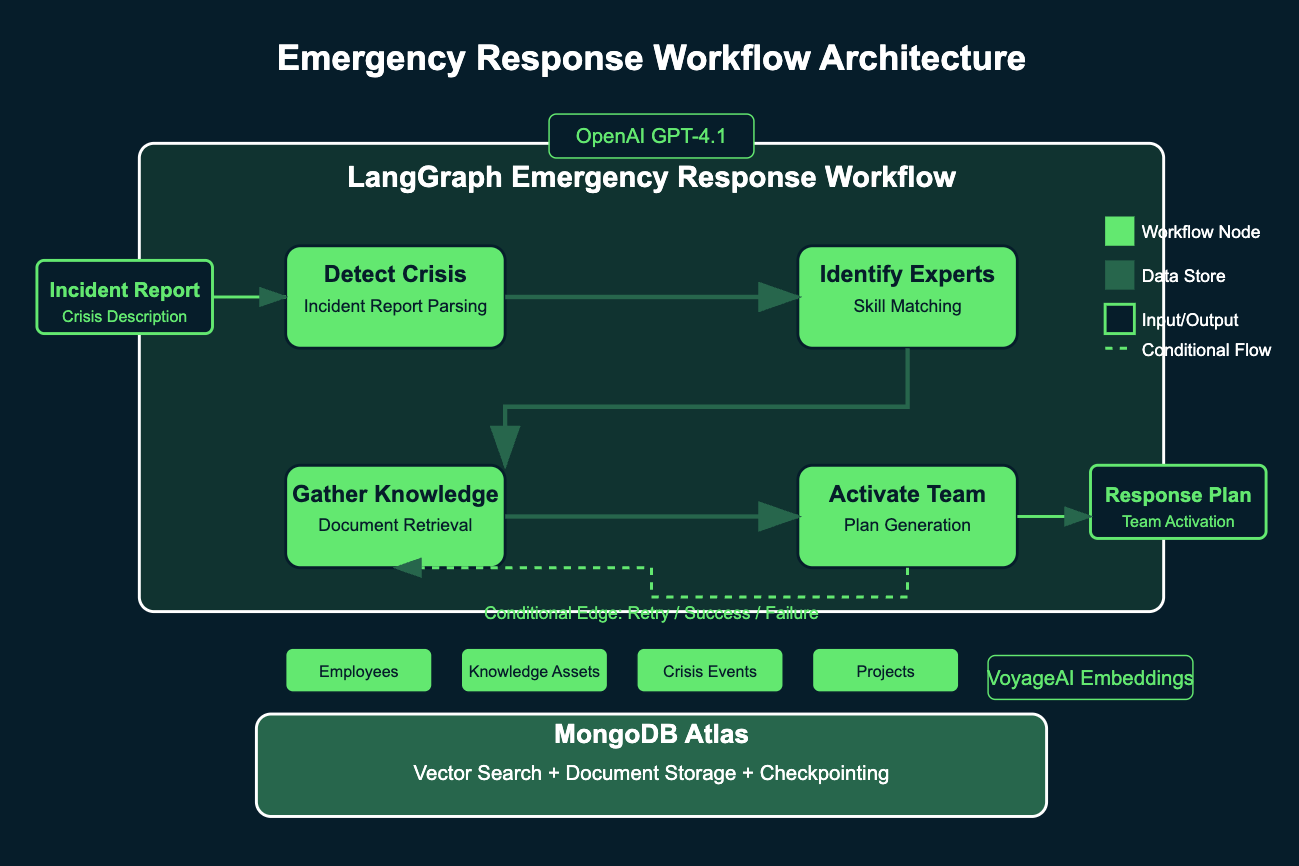

#### Creating an Crisis Event Collection with Vector and Search Indexes

In [ ]:
CRISIS_EVENT_COLLECTION = "crisis_events"

existing_collections = db.list_collection_names()

# Create collection
if CRISIS_EVENT_COLLECTION not in existing_collections:
    db.create_collection(CRISIS_EVENT_COLLECTION)
    print(f"Created {CRISIS_EVENT_COLLECTION} collection")
else:
    print(f"{CRISIS_EVENT_COLLECTION} collection already exists")

crisis_events collection already exists


In [97]:
# Create search and vector indexes
create_vector_search_index(
    db[CRISIS_EVENT_COLLECTION], f"{CRISIS_EVENT_COLLECTION}_vector_search_index"
)
create_text_search_index(
    db[CRISIS_EVENT_COLLECTION],
    {"mappings": {"dynamic": True}},
    f"{CRISIS_EVENT_COLLECTION}_text_search_index",
)

Vector search index 'crisis_events_vector_search_index' already exists.
Search index 'crisis_events_text_search_index' created successfully


'crisis_events_text_search_index'

#### Creating Data Model for Crisis Event

In [98]:
from datetime import datetime
from enum import Enum


# Minimal enums
class CrisisType(str, Enum):
    NETWORK_OUTAGE = "Network Outage"
    SECURITY_BREACH = "Security Breach"
    SYSTEM_FAILURE = "System Failure"
    INFRASTRUCTURE_FAILURE = "Infrastructure Failure"


class SeverityLevel(str, Enum):
    LOW = "low"
    MEDIUM = "medium"
    HIGH = "high"
    CRITICAL = "critical"


# Minimal CrisisEvent Model
class CrisisEvent(BaseModel):
    event_id: str = Field(..., description="Unique crisis identifier")
    event_type: CrisisType = Field(..., description="Type of crisis")
    severity: SeverityLevel = Field(..., description="Crisis severity level")
    title: str = Field(..., description="Brief crisis description")
    description: str = Field(..., description="Detailed crisis description")
    affected_systems: List[str] = Field(
        default_factory=list, description="Affected systems/services"
    )
    affected_regions: List[str] = Field(
        default_factory=list, description="Affected geographical regions"
    )
    customer_impact: str = Field(
        ..., description="Estimated customer impact description"
    )
    required_skills: List[str] = Field(
        default_factory=list, description="Skills needed for response"
    )

#### Creating an Incident Report Parser

In [99]:
class IncidentReportParser:
    def parse_incident_report(self, incident_report: str) -> CrisisEvent:
        """Parse incident report text and create CrisisEvent object"""

        # Create a prompt for GPT-4.1 to parse the incident report
        prompt = f"""
    Parse the following incident report and extract information to create a CrisisEvent.

    Incident Report:
    {incident_report}

    Extract the following information:
    1. event_type: Determine the type (Network Outage, Security Breach, System Failure, Infrastructure Failure)
    2. severity: Determine severity level (low, medium, high, critical)
    3. title: Create a brief title (max 100 characters)
    4. description: Extract or create a detailed description (max 500 characters)
    5. affected_systems: List of affected systems/services
    6. affected_regions: List of affected geographical regions
    7. customer_impact: Estimated impact on customers
    8. required_skills: Skills needed to respond to this crisis

    Generate a unique event_id in the format: CRISIS-YYYYMMDD-XXX

    Return ONLY a JSON object that matches the CrisisEvent schema exactly.
    """

        try:
            # Parse with GPT-4.1
            response = openai_client.responses.parse(
                model="gpt-4.1", input=prompt, text_format=CrisisEvent
            )

            crisis_event = response.output_parsed

            return crisis_event

        except Exception as e:
            print(f"Error parsing incident report: {e}")
            # Fallback to basic crisis event
            return self._create_fallback_crisis(incident_report)

    def _create_fallback_crisis(self, incident_report: str) -> CrisisEvent:
        """Create a basic crisis event if parsing fails"""
        today = datetime.now()
        event_id = f"CRISIS-{today.strftime('%Y%m%d')}-001"

        return CrisisEvent(
            event_id=event_id,
            event_type=CrisisType.SYSTEM_FAILURE,
            severity=SeverityLevel.MEDIUM,
            title="Unknown Crisis Event",
            description=incident_report[:500],  # Truncate to 500 chars
            affected_systems=["Unknown"],
            affected_regions=["Unknown"],
            customer_impact="Assessment required",
            required_skills=["General IT Support"],
        )

#### Testing The Incident Report Parser

In [100]:
# Example incident report (single string)
incident_report = """
  NETWORK CRISIS REPORT - PRIORITY CRITICAL

  Incident #: INC-20250505-3547
  Service: 5G Network Service
  Status: ACTIVE OUTAGE

  SUMMARY:
  Complete 5G network failure reported across North America region

  AFFECTED AREAS:
  - New York City metro area
  - Boston metropolitan region
  - Philadelphia and surrounding counties

  IMPACT ASSESSMENT:
  - Estimated 2 million customers unable to access 5G services
  - Enterprise customers reporting business-critical service disruptions
  - Mobile data speeds degraded to 4G in surrounding areas

  TECHNICAL DETAILS:
  - Core Network Status: DOWN
  - gNodeB Stations: 3/5 nodes failed
  - Data Center: Primary facility shows hardware failures
  - Root Cause: Equipment overheating during maintenance window

  TIMELINE:
  15:00 EST - Maintenance window begins
  15:25 EST - First customer complaints received
  15:30 EST - Network monitoring alerts triggered
  15:45 EST - Service outage confirmed

  REQUIRED RESPONSE:
  - Network engineers with 5G expertise
  - Hardware repair technicians
  - Crisis management team
  - Customer communications team

  BUSINESS IMPACT:
  - Revenue impact: $5,000/minute
  - SLA breach: Yes (2-hour response requirement)
  - Media attention: High (local news coverage)

  NEXT STEPS:
  1. Activate emergency response protocol
  2. Dispatch on-site technicians
  3. Prepare customer communications
  4. Assess backup systems deployment
"""

In [101]:
parser = IncidentReportParser()

# Parse incident report
print("=== Processing Incident Report ===")

# Parse incident report into CrisisEvent
crisis_event = parser.parse_incident_report(incident_report)

# Display results
print(f"Event ID: {crisis_event.event_id}")
print(f"Type: {crisis_event.event_type}")
print(f"Severity: {crisis_event.severity}")
print(f"Title: {crisis_event.title}")
print(f"Description: {crisis_event.description}")
print(f"Affected Systems: {', '.join(crisis_event.affected_systems)}")
print(f"Affected Regions: {', '.join(crisis_event.affected_regions)}")
print(f"Customer Impact: {crisis_event.customer_impact}")
print(f"Required Skills: {', '.join(crisis_event.required_skills)}")
print()

=== Processing Incident Report ===
Event ID: CRISIS-20250505-001
Type: CrisisType.NETWORK_OUTAGE
Severity: SeverityLevel.CRITICAL
Title: Critical 5G Network Outage Affecting Major US Metropolitan Regions
Description: A complete 5G network failure is impacting North America, affecting millions of customers in major cities. Core network is down, several gNodeB stations have failed, and primary data center hardware is compromised due to overheating during maintenance. This has led to severe business and public disruptions.
Affected Systems: 5G Network Service, Core Network, gNodeB Stations, Primary Data Center
Affected Regions: New York City metro area, Boston metropolitan region, Philadelphia and surrounding counties
Customer Impact: Approx. 2 million customers unable to access 5G; business-critical disruptions; degraded service to 4G in surrounding areas.
Required Skills: Network engineering (5G expertise), Hardware repair technicians, Crisis management, Customer communications



#### Creating an Issue Response Engine

In [102]:
class IssueResponseEngine:
    def __init__(self, db):
        self.db = db

    def crisis_detection_and_parsing(self, incident_report):
        """Integrates incident report parsing with emergency response"""

        # Initialize a parser
        parser = IncidentReportParser()

        # Parse incident into CrisisEvent
        crisis_event = parser.parse_incident_report(incident_report)

        # Save to MongoDB
        db.crisis_events.insert_one(crisis_event.model_dump())
        print("Crisis event saved into records")

        # Initialize emergency response
        crisis_data = crisis_event.model_dump()

        print("Crisis Event Generated:")
        print(json.dumps(crisis_event.model_dump(), indent=2))

        return crisis_data

    def experts_identification(self, crisis_data, limit=5):
        """Identifies experts with required skills"""
        # Use the skills data in the crisis_data to search the employees for the right skills
        skills_to_search_against = crisis_data["required_skills"]

        # Create search query focusing on the skills array and bio fields
        search_query = f"Find experts with {', '.join(skills_to_search_against)} in their skills and experience"

        print(f"Search Query: {search_query}")

        # Use hybrid search to retrieve employees with the right skills
        results = hybrid_search(
            collection=db[EMPLOYEES_COLLECTION],
            text_key="bio",
            query=search_query,
            top_k=limit,
        )

        return results

    def knowledge_asset_gathering(self, crisis_data, limit=5):
        """Gather relevant knowledge assets for the team"""

        # Look for knowledge assets that are semantically similar to the crisis event description
        search_query = crisis_data["description"]

        # Use semantic search to retrieve knowledge assets
        results = semantic_search(
            collection=self.db[KNOWLEDGE_ASSETS_COLLECTION],
            text_key="content",
            query=search_query,
            top_k=limit,
        )

        return results

    def team_activation_and_brief(
        self, crisis_data, experts_identified, knowledge_assets
    ):
        """Create response plan and activate team"""

        try:
            # Prepare the prompt with crisis and team information
            prompt = f"""
      CRISIS EVENT BRIEFING

      Crisis Details:
      - Event ID: {crisis_data.get('event_id')}
      - Type: {crisis_data.get('event_type')}
      - Severity: {crisis_data.get('severity')}
      - Title: {crisis_data.get('title')}
      - Description: {crisis_data.get('description')}
      - Affected Systems: {', '.join(crisis_data.get('affected_systems', []))}
      - Affected Regions: {', '.join(crisis_data.get('affected_regions', []))}
      - Customer Impact: {crisis_data.get('customer_impact')}

      Response Team:
      {self._format_team_members(experts_identified)}

      Relevant Knowledge Assets:
      {self._format_knowledge_assets(knowledge_assets)}

      INSTRUCTIONS:
      Create a detailed briefing for the emergency response team that includes:
      1. Executive summary of the crisis
      2. Team assignments with specific roles
      3. Priority action items
      4. Available resources and documentation
      5. Expected timeline and milestones
      6. Communication protocols
      7. Success criteria for resolution

      Keep the briefing concise but comprehensive.
      """

            # Call GPT-4.1 to generate briefing
            response = openai_client.responses.create(
                model="gpt-4.1",
                input=prompt,
            )

            briefing_text = response.output_text

            print("Briefing Generated:")
            print(briefing_text)

            return briefing_text

        except Exception as e:
            print(f"Error generating briefing: {e}")

    def _format_team_members(self, experts):
        """Format expert list for briefing"""
        formatted = []
        for i, expert in enumerate(experts):
            role = self._assign_crisis_role(expert)
            formatted.append(
                f"- {expert.get('name')} ({expert.get('role')}) - Crisis Role: {role}"
            )
        return "\n".join(formatted)

    def _format_knowledge_assets(self, assets):
        """Format knowledge assets for briefing"""
        if not assets:
            return "No specific knowledge assets found."
        formatted = []
        for asset in assets[:5]:  # Limit to top 5
            formatted.append(f"- {asset.get('title')} (Type: {asset.get('type')})")
        return "\n".join(formatted)

    def _assign_crisis_role(self, expert):
        """Assign crisis-specific role based on expert skills"""
        skills = expert.get("matching_skills", [])
        if any("5G" in skill for skill in skills):
            return "Technical Lead"
        elif any("Security" in skill for skill in skills):
            return "Security Specialist"
        elif any("Network" in skill for skill in skills):
            return "Network Specialist"
        else:
            return "Technical Support"

#### Creating Emergency Response State and Workflow

In [103]:
import operator
from datetime import datetime
from typing import Annotated, Any, Dict, List, TypedDict

import langgraph.graph as lg
from langchain.schema import BaseMessage
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.checkpoint.mongodb import MongoDBSaver


# Define state for the crisis response graph
class EmergencyResponseState(TypedDict):
    """State for the emergency response workflow"""

    incident_report: str  # Incident report text
    crisis_event: Dict[str, Any]  # Crisis details
    skill_requirements: Optional[List[str]]  # Required skills
    available_experts: Optional[List[Dict[str, Any]]]  # Identified experts
    selected_team: Optional[List[Dict[str, Any]]]  # Final team composition
    relevant_knowledge: Optional[List[Dict[str, Any]]]  # Knowledge assets
    response_plan: Optional[Dict[str, Any]]  # Final response plan
    # messages: List[Union[HumanMessage, AIMessage]]  # Conversation history
    messages: Annotated[List[BaseMessage], operator.add]
    errors: Optional[List[str]]  # Any errors encountered

In [43]:
class EmergencyResponseWorkflow:
    """Orchestrates the emergency response workflow using LangGraph"""

    def __init__(self, client, db, collection_names):
        self.client = client
        self.db = db
        self.employees_collection = db[collection_names["employees"]]
        self.projects_collection = db[collection_names["projects"]]
        self.knowledge_collection = db[collection_names["knowledge_assets"]]

        # Initialize IssueResponseEngine
        self.issue_engine = IssueResponseEngine(db)

        # Create MongoDB checkpointer
        self.checkpoint_store = MongoDBSaver(client, DB_NAME, "checkpoints")

        # Build the graph
        self.workflow = self._build_graph()

    def _detect_crisis_and_requirements(
        self, state: EmergencyResponseState
    ) -> EmergencyResponseState:
        """Detect crisis parameters and determine skill requirements"""
        print("\n")
        print("1. Beginning crisis detecting and parsing provided information...")
        try:
            incident_report = state["incident_report"]

            # Use IssueResponseEngine to parse incident and create crisis data
            crisis_data = self.issue_engine.crisis_detection_and_parsing(
                incident_report
            )

            state["crisis_event"] = crisis_data

            # Update skill requirements from crisis data
            state["skill_requirements"] = crisis_data.get("required_skills", [])

            state["messages"].append(
                AIMessage(
                    content=f"Crisis detected: {crisis_data.get('event_type')}. Severity: {crisis_data.get('severity')}. "
                    f"Required skills identified: {', '.join(state['skill_requirements'])}"
                )
            )

        except Exception as e:
            error_msg = f"Error detecting crisis requirements: {e!s}"
            state["errors"] = state.get("errors", []) + [error_msg]
            state["messages"].append(AIMessage(content=error_msg))

        return state

    def _identify_experts(
        self, state: EmergencyResponseState
    ) -> EmergencyResponseState:
        """Identify available experts with required skills"""
        print("\n")
        print(
            "2. Identifying experts within records suitable to handle crisis event..."
        )
        try:
            # Use IssueResponseEngine to identify experts
            crisis_data = state["crisis_event"]
            available_experts = self.issue_engine.experts_identification(crisis_data, 5)

            # Format experts for consistency with existing state structure
            formatted_experts = []
            for expert in available_experts:
                expert = expert.metadata
                formatted_experts.append(
                    {
                        "emp_id": expert.get("emp_id"),
                        "name": expert.get("name"),
                        "role": expert.get("role"),
                        "department": expert.get("department"),
                        "bio": expert.get("bio"),
                        "skills": expert.get("skills", []),
                        "current_projects": expert.get("current_projects", []),
                    }
                )

            print("Below are the experts identified ⬇️")
            print(formatted_experts)

            # The available experts are the selected team
            # TODO: Create a process that organizes the team based on the available experts
            state["selected_team"] = formatted_experts
            state["messages"].append(
                AIMessage(
                    content=f"Identified {len(formatted_experts)} available experts with required skills."
                )
            )

        except Exception as e:
            print(e)
            error_msg = f"Error identifying experts: {e!s}"
            # Fix for the second error
            if state.get("errors") is None:
                state["errors"] = [error_msg]
            else:
                state["errors"] = state.get("errors", []) + [error_msg]
            state["messages"].append(AIMessage(content=error_msg))

        return state

    def _gather_knowledge_assets(
        self, state: EmergencyResponseState
    ) -> EmergencyResponseState:
        """Gather relevant knowledge assets for the team"""
        print("\n")
        print("3. Gathering knowledge assets to prep team on...")

        try:
            # Use IssueResponseEngine to gather knowledge assets
            crisis_data = state["crisis_event"]
            knowledge_assets = self.issue_engine.knowledge_asset_gathering(crisis_data)
            print("Below are the knowledge assets gathered ⬇️")

            # Format knowledge assets for consistency
            formatted_assets = []
            for asset in knowledge_assets:
                # Handle tuple format (Document, score)
                if isinstance(asset, tuple):
                    doc = asset[0]
                    if hasattr(doc, "metadata"):
                        asset_data = doc.metadata
                    else:
                        asset_data = doc
                elif hasattr(asset, "metadata"):
                    asset_data = asset.metadata
                else:
                    asset_data = asset

                formatted_assets.append(
                    {
                        "asset_id": asset_data.get("asset_id", "unknown"),
                        "title": asset_data.get("title", "Untitled Asset"),
                        "type": asset_data.get("type", "documentation"),
                        "author": asset_data.get("author", "Unknown"),
                        "content": asset_data.get("content", ""),
                        "creation_date": asset_data.get("creation_date", ""),
                    }
                )

            print(formatted_assets)

            state["relevant_knowledge"] = formatted_assets
            state["messages"].append(
                AIMessage(
                    content=f"Gathered {len(formatted_assets)} relevant knowledge assets for the team."
                )
            )

        except Exception as e:
            print("Error gethering knowledge assets ❌")
            print(e)
            error_msg = f"Error gathering knowledge assets: {e!s}"
            state["errors"] = state.get("errors", []) + [error_msg]
            state["messages"].append(AIMessage(content=error_msg))

        return state

    def _generate_action_items(
        self, crisis_event: Dict[str, Any], selected_team: List[Dict[str, Any]]
    ) -> List[Dict[str, Any]]:
        """Generate action items based on crisis event and team composition"""
        action_items = []

        # Extract crisis information
        event_type = crisis_event.get("event_type", "Unknown")
        severity = crisis_event.get("severity", "low")
        affected_areas = crisis_event.get("affected_areas", [])

        # Base action items for all crises
        action_items.append(
            {
                "title": "Assess situation and confirm details",
                "priority": "critical",
                "assigned_to": selected_team[0]["name"]
                if selected_team
                else "Team Lead",
                "status": "pending",
                "estimated_duration": "15 minutes",
            }
        )

        # Generate specific action items based on crisis type
        if "network" in event_type.lower() or "5g" in event_type.lower():
            action_items.extend(
                [
                    {
                        "title": "Check network infrastructure status",
                        "priority": "critical",
                        "assigned_to": "Network Engineer",
                        "status": "pending",
                        "estimated_duration": "30 minutes",
                    },
                    {
                        "title": "Dispatch field technicians to affected areas",
                        "priority": "high",
                        "assigned_to": "Field Operations Manager",
                        "status": "pending",
                        "estimated_duration": "45 minutes",
                    },
                    {
                        "title": "Prepare customer communication",
                        "priority": "high",
                        "assigned_to": "Communications Team",
                        "status": "pending",
                        "estimated_duration": "20 minutes",
                    },
                ]
            )

        # Add severity-based actions
        if severity == "critical":
            action_items.append(
                {
                    "title": "Activate backup systems",
                    "priority": "critical",
                    "assigned_to": "Infrastructure Team",
                    "status": "pending",
                    "estimated_duration": "60 minutes",
                }
            )

            action_items.append(
                {
                    "title": "Notify senior management",
                    "priority": "high",
                    "assigned_to": "Crisis Manager",
                    "status": "pending",
                    "estimated_duration": "10 minutes",
                }
            )

        # Assign team members to action items
        for i, action in enumerate(action_items):
            if i < len(selected_team) and action["assigned_to"] in [
                "Team Lead",
                "Network Engineer",
                "Field Operations Manager",
                "Communications Team",
                "Infrastructure Team",
                "Crisis Manager",
            ]:
                # Try to match skills to action items
                for member in selected_team:
                    member_skills = [
                        skill.lower() for skill in member.get("skills", [])
                    ]
                    if (
                        "network" in action["title"].lower()
                        and any("network" in skill for skill in member_skills)
                    ) or (
                        "communication" in action["title"].lower()
                        and any("communication" in skill for skill in member_skills)
                    ):
                        action["assigned_to"] = member["name"]
                        break
                else:
                    # Default assignment if no skill match
                    action["assigned_to"] = selected_team[i % len(selected_team)][
                        "name"
                    ]

        return action_items

    def _activate_team_and_create_plan(
        self, state: EmergencyResponseState
    ) -> EmergencyResponseState:
        """Create response plan and activate team"""
        print("4. Activating team and creating a response plan...")

        try:
            # TODO: Send an email to all employees selected and include response plan
            selected_team = state["selected_team"]
            crisis_event = state["crisis_event"]
            relevant_knowledge = state["relevant_knowledge"]

            # Use IssueResponseEngine to create team briefing
            briefing_text = self.issue_engine.team_activation_and_brief(
                crisis_event, selected_team, relevant_knowledge
            )

            # Create response plan
            response_plan = {
                "crisis_id": f"CRISIS-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
                "team_lead": selected_team[0] if selected_team else None,
                "team_members": selected_team,
                "crisis_details": crisis_event,
                "briefing": briefing_text,
                "action_items": self._generate_action_items(
                    crisis_event, selected_team
                ),
                "knowledge_resources": relevant_knowledge,
                "status": "active",
                "created_at": datetime.now().isoformat(),
                "expected_resolution_time": self._estimate_resolution_time(
                    crisis_event
                ),
            }

            # Create summary for team activation
            activation_summary = self._create_activation_summary(response_plan)

            state["response_plan"] = response_plan
            state["messages"].append(
                AIMessage(
                    content=f"Emergency response team activated. Plan created: {activation_summary}"
                )
            )

        except Exception as e:
            error_msg = f"Error activating team: {e!s}"
            state["errors"] = state.get("errors", []) + [error_msg]
            state["messages"].append(AIMessage(content=error_msg))

        return state

    def _estimate_resolution_time(self, crisis_event: Dict[str, Any]) -> str:
        """Estimate resolution time based on crisis severity"""
        severity = crisis_event.get("severity", "low")
        if severity == "critical":
            return "1-2 hours"
        elif severity == "high":
            return "4-8 hours"
        else:
            return "24-48 hours"

    def _create_activation_summary(self, response_plan: Dict[str, Any]) -> str:
        """Create summary for team activation"""
        team_size = len(response_plan["team_members"])
        team_lead = (
            response_plan["team_lead"]["name"] if response_plan["team_lead"] else "None"
        )
        crisis_type = response_plan["crisis_details"].get("event_type", "Unknown")
        resolution_time = response_plan["expected_resolution_time"]

        return (
            f"Crisis {response_plan['crisis_id']}: {crisis_type} response team activated. "
            f"Team of {team_size} led by {team_lead}. Expected resolution: {resolution_time}"
        )

    def _should_continue(self, state: EmergencyResponseState) -> str:
        """Determine if workflow should continue or end"""
        if state.get("errors") and len(state["errors"]) < 3:
            # Retry if we have minor errors
            print("There were minor errors so retrying...")
            print(state["errors"])
            return "retry"
        elif not state.get("selected_team"):
            # End if no team could be formed
            return "end_failure"
        else:
            # Continue to completion
            return "end_success"

    def _build_graph(self):
        """Build the LangGraph workflow"""
        # Define the graph
        builder = lg.StateGraph(EmergencyResponseState)

        # Add nodes
        builder.add_node("detect_crisis", self._detect_crisis_and_requirements)
        builder.add_node("identify_experts", self._identify_experts)
        builder.add_node("gather_knowledge", self._gather_knowledge_assets)
        builder.add_node("activate_team", self._activate_team_and_create_plan)

        # Define edges
        builder.add_edge("detect_crisis", "identify_experts")
        builder.add_edge("identify_experts", "gather_knowledge")
        builder.add_edge("gather_knowledge", "activate_team")

        # Add conditional edge for completion
        builder.add_conditional_edges(
            "activate_team",
            self._should_continue,
            {"retry": "detect_crisis", "end_success": lg.END, "end_failure": lg.END},
        )

        # Set entry point
        builder.set_entry_point("detect_crisis")

        # Compile the graph with MongoDB checkpointing
        return builder.compile(checkpointer=self.checkpoint_store)

    def respond_to_crisis(self, incident_report) -> Dict[str, Any]:
        """Respond to an emergency crisis event"""
        # Initialize state
        initial_state = EmergencyResponseState(
            incident_report=incident_report,
            crisis_event={},
            skill_requirements=None,
            available_experts=None,
            selected_team=None,
            relevant_knowledge=None,
            response_plan=None,
            messages=[HumanMessage(content=incident_report)],
            errors=[],
        )

        # Run the workflow
        config = {"configurable": {"thread_id": 1}}
        final_state = self.workflow.invoke(initial_state, config)

        return final_state

#### ⭐️ Executing Emergency Response Worklfow

In [120]:
# Initialize the workflow
collection_names = {
    "employees": EMPLOYEES_COLLECTION,
    "projects": PROJECTS_COLLECTION,
    "knowledge_assets": KNOWLEDGE_ASSETS_COLLECTION,
}

incident_report = """
  NETWORK CRISIS REPORT - PRIORITY CRITICAL

  Incident #: INC-20250505-3547
  Service: 5G Network Service
  Status: ACTIVE OUTAGE

  SUMMARY:
  Complete 5G network failure reported across North America region

  AFFECTED AREAS:
  - New York City metro area
  - Boston metropolitan region
  - Philadelphia and surrounding counties

  IMPACT ASSESSMENT:
  - Estimated 2 million customers unable to access 5G services
  - Enterprise customers reporting business-critical service disruptions
  - Mobile data speeds degraded to 4G in surrounding areas

  TECHNICAL DETAILS:
  - Core Network Status: DOWN
  - gNodeB Stations: 3/5 nodes failed
  - Data Center: Primary facility shows hardware failures
  - Root Cause: Equipment overheating during maintenance window

  TIMELINE:
  15:00 EST - Maintenance window begins
  15:25 EST - First customer complaints received
  15:30 EST - Network monitoring alerts triggered
  15:45 EST - Service outage confirmed

  REQUIRED RESPONSE:
  - Network engineers with 5G expertise
  - Hardware repair technicians
  - Crisis management team
  - Customer communications team

  BUSINESS IMPACT:
  - Revenue impact: $5,000/minute
  - SLA breach: Yes (2-hour response requirement)
  - Media attention: High (local news coverage)

  NEXT STEPS:
  1. Activate emergency response protocol
  2. Dispatch on-site technicians
  3. Prepare customer communications
  4. Assess backup systems deployment
"""

emergency_workflow = EmergencyResponseWorkflow(db_client, db, collection_names)

# Execute the complete workflow starting from incident report
print("=== Emergency Response System Activated ===")
result = emergency_workflow.respond_to_crisis(
    incident_report
)  # Empty dict to trigger detection & parsing

# Print results
if result.get("response_plan"):
    print(f"\nCrisis ID: {result['response_plan']['crisis_id']}")
    print(f"Team Lead: {result['response_plan']['team_lead']['name']}")
    print(f"Team Size: {len(result['response_plan']['team_members'])}")
    print(f"Expected Resolution: {result['response_plan']['expected_resolution_time']}")

    print("\nTeam Composition:")
    for member in result["response_plan"]["team_members"]:
        print(f"- {member['name']} ({member['assigned_role']})")

    print("\nAction Items:")
    for action in result["response_plan"]["action_items"]:
        print(f"- {action['title']} (Priority: {action['priority']})")

    print("\nBriefing:")
    print(result["response_plan"]["briefing"])
else:
    print("Failed to create emergency response plan")

=== Emergency Response System Activated ===


1. Beginning crisis detecting and parsing provided information...
Crisis event saved into records
Crisis Event Generated:
{
  "event_id": "CRISIS-20250505-001",
  "event_type": "Network Outage",
  "severity": "critical",
  "title": "Critical 5G Network Outage Across Major North American Cities",
  "description": "A complete 5G network failure affects core infrastructure in New York City, Boston, and Philadelphia, impacting 2 million customers. Root cause linked to hardware overheating during a maintenance window, resulting in major service disruptions to enterprises and severe business impact.",
  "affected_systems": [
    "5G Network Service",
    "Core Network",
    "gNodeB Stations",
    "Primary Data Center"
  ],
  "affected_regions": [
    "New York City metro area",
    "Boston metropolitan region",
    "Philadelphia and surrounding counties"
  ],
  "customer_impact": "Estimated 2 million customers unable to access 5G; enterprise clie

  0%|          | 0/1 [00:00<?, ?it/s]

Below are the experts identified ⬇️
[{'emp_id': 'employees-9', 'name': 'Aisha Patel', 'role': 'Network Engineer', 'department': 'Network Operations', 'bio': None, 'skills': ['LTE/5G Networking', 'Network Security', 'Cisco Routers & Switches', 'RF Planning', 'Troubleshooting', 'Fiber Optic Communications', 'Data Center Networking'], 'current_projects': []}, {'emp_id': 'employees-5', 'name': 'Sarah Kim', 'role': 'Network Engineer', 'department': 'Network Operations', 'bio': None, 'skills': ['Network Design', 'Telecommunications Infrastructure', 'Fiber Optic Networking', 'Routing & Switching', 'VoIP', 'Troubleshooting', 'Cisco Certified'], 'current_projects': []}, {'emp_id': 'employees-7', 'name': 'Sophia Kim', 'role': 'Network Engineer', 'department': 'Network Operations', 'bio': None, 'skills': ['IP routing', 'network design', 'fiber optics', 'troubleshooting', 'VoIP'], 'current_projects': []}, {'emp_id': 'employees-4', 'name': 'Maya Patel', 'role': 'Network Engineer', 'department': 'Ne

  0%|          | 0/1 [00:00<?, ?it/s]

Below are the knowledge assets gathered ⬇️
[{'asset_id': 'knowledge_assets-3', 'title': 'Best Practices for API Deployment and Version Management', 'type': 'best_practice', 'author': 'employees-6', 'content': '', 'creation_date': '2024-06-18'}, {'asset_id': 'knowledge_assets-3', 'title': 'Standard Procedures and Best Practices for Secure API Development', 'type': 'best_practice', 'author': 'employees-4', 'content': '', 'creation_date': '2024-06-15T09:25:00Z'}, {'asset_id': 'knowledge_assets-4', 'title': 'CI/CD Pipeline Setup: Best Practices and Technical Procedures', 'type': 'documentation', 'author': 'employees-7', 'content': '', 'creation_date': '2024-06-12'}, {'asset_id': 'knowledge_assets-2', 'title': 'Continuous Integration and Deployment (CI/CD) Best Practices for Microservices', 'type': 'best_practice', 'author': 'employees-4', 'content': '', 'creation_date': '2024-06-28'}, {'asset_id': 'knowledge_assets-1', 'title': 'Continuous Integration and Deployment (CI/CD) Pipeline Best P

DocumentTooLarge: 'update' command document too large

### **SCENARIO : Critical 5G Network Issue Response (Agentic AI )**
    



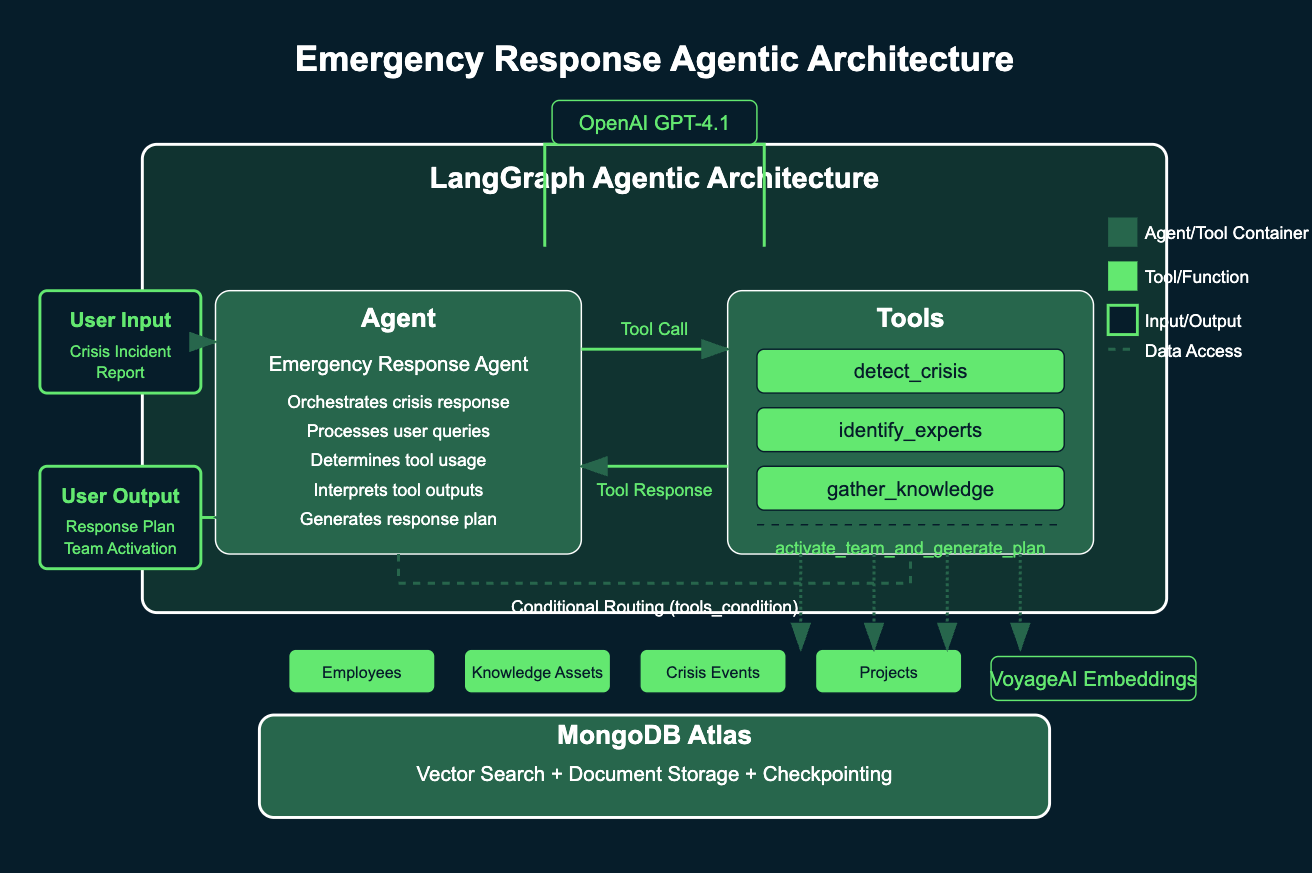

#### Turning Processes Into Tools

In [105]:
from langchain.agents import tool

emergency_workflow = EmergencyResponseWorkflow(db_client, db, collection_names)
issue_engine = IssueResponseEngine(db)


@tool
def detect_crisis(incident_report: str) -> Dict[str, Any]:
    """
    Analyzes an incident report to detect crisis parameters and determine required skills.

    This tool parses unstructured incident reports to extract critical information about
    the crisis event, including its type, severity, affected systems, and the skills needed
    for an effective response. It utilizes a specialized parsing engine to convert freeform
    text into structured data that can be used for emergency response coordination.

    Args:
        incident_report (str): The full text of the incident report describing the emergency.

    Returns:
        Dict[str, Any]: A dictionary containing:
            - event_id (str): Unique identifier for the crisis
            - event_type (str): Type of crisis (e.g., Network Outage, Security Breach)
            - severity (str): Severity level (critical, high, medium, low)
            - title (str): Short descriptive title
            - description (str): Detailed crisis description
            - affected_systems (List[str]): Systems impacted by the crisis
            - affected_regions (List[str]): Geographical regions affected
            - customer_impact (str): Description of impact on customers
            - required_skills (List[str]): Skills needed to address the crisis

    Raises:
        Exception: If there is an error parsing the incident report or extracting required information.

    Example:
        >>> incident_report = "NETWORK CRISIS REPORT - PRIORITY CRITICAL\\n..."
        >>> crisis_data = detect_crisis(incident_report, issue_engine)
        >>> print(f"Crisis: {crisis_data['event_type']}, Severity: {crisis_data['severity']}")
        Crisis: Network Outage, Severity: critical
    """
    try:
        # Use IssueResponseEngine to parse incident and create crisis data
        crisis_data = issue_engine.crisis_detection_and_parsing(incident_report)

        # Log the detection
        print("\n1. Crisis detected and parsed:")
        print(f"- Type: {crisis_data.get('event_type')}")
        print(f"- Severity: {crisis_data.get('severity')}")
        print(f"- Required skills: {', '.join(crisis_data.get('required_skills', []))}")

        return crisis_data

    except Exception as e:
        error_msg = f"Error detecting crisis requirements: {e!s}"
        print(f"⚠️ {error_msg}")
        raise Exception(error_msg)

/Users/richmondalake/miniconda3/lib/python3.11/site-packages/langchain/chains/api/base.py:57: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.utilities.requests import TextRequestsWrapper
/Users/richmondalake/miniconda3/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:918: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `TextRequestsWrapper` to V2.
  warn(


In [106]:
@tool
def identify_experts(crisis_data: str) -> str:
    """
    Identifies and ranks available experts with skills relevant to the crisis.

    This tool searches the employee database to find personnel with the specific skills
    required to address the current crisis. It evaluates their expertise, availability,
    and relevance to create a ranked list of suitable experts who can be assembled into
    a response team.

    Args:
        crisis_data (Dict[str, Any]): Structured data about the crisis event, including required skills.
        issue_engine: An instance of IssueResponseEngine with access to employee data.

    Returns:
        List[Dict[str, Any]]: A list of expert profiles containing:
            - emp_id (str): Employee identifier
            - name (str): Employee name
            - role (str): Job role/title
            - department (str): Department
            - bio (str): Brief professional biography
            - skills (List[str]): List of professional skills
            - current_projects (List[str]): Currently assigned projects

    Raises:
        Exception: If there is an error searching for experts or processing expert data.

    Example:
        >>> crisis_data = {"event_type": "Network Outage", "required_skills": ["5G network engineering"]}
        >>> experts = identify_experts(crisis_data, issue_engine)
        >>> print(f"Found {len(experts)} suitable experts")
        Found 5 suitable experts
    """
    try:
        # Use IssueResponseEngine to identify experts
        print("\n2. Identifying experts with required skills:")

        # Convert crisis data into an object
        crisis_data = json.loads(crisis_data)

        available_experts = issue_engine.experts_identification(crisis_data)

        # Format experts for consistency
        formatted_experts = []
        for expert in available_experts:
            if hasattr(expert, "metadata"):
                expert_data = expert.metadata
            else:
                expert_data = expert

            formatted_experts.append(
                {
                    "emp_id": expert_data.get("emp_id"),
                    "name": expert_data.get("name"),
                    "role": expert_data.get("role"),
                    "department": expert_data.get("department"),
                    "bio": expert_data.get("bio", ""),
                    "skills": expert_data.get("skills", []),
                    "current_projects": expert_data.get("current_projects", []),
                }
            )

        print(f"- Identified {len(formatted_experts)} experts with relevant skills")
        for i, expert in enumerate(formatted_experts, 1):
            print(f"  {i}. {expert['name']} ({expert['role']})")

        return formatted_experts

    except Exception as e:
        error_msg = f"Error identifying experts: {e!s}"
        print(f"⚠️ {error_msg}")
        raise Exception(error_msg)

In [107]:
@tool
def gather_knowledge(crisis_data: str) -> str:
    """
    Retrieves relevant knowledge assets to support the emergency response team.

    This tool searches the knowledge base for documentation, procedures, and historical
    information relevant to the current crisis. It identifies technical guides, best
    practices, and previous incident reports that can assist the response team in
    addressing the crisis effectively.

    Args:
        crisis_data (Dict[str, Any]): Structured data about the crisis event.
        issue_engine: An instance of IssueResponseEngine with access to knowledge assets.

    Returns:
        List[Dict[str, Any]]: A list of knowledge assets containing:
            - asset_id (str): Unique identifier for the asset
            - title (str): Title of the knowledge asset
            - type (str): Type of asset (e.g., documentation, best_practice, procedure)
            - author (str): Creator of the asset
            - content (str): Content of the knowledge asset
            - creation_date (str): When the asset was created

    Raises:
        Exception: If there is an error retrieving or processing knowledge assets.

    Example:
        >>> crisis_data = {"event_type": "Network Outage", "affected_systems": ["5G Network"]}
        >>> assets = gather_knowledge(crisis_data, issue_engine)
        >>> print(f"Found {len(assets)} relevant knowledge assets")
        Found 5 relevant knowledge assets
    """
    try:
        # Use IssueResponseEngine to gather knowledge assets
        print("\n3. Gathering relevant knowledge assets:")

        crisis_data = json.loads(crisis_data)

        knowledge_assets = issue_engine.knowledge_asset_gathering(crisis_data)

        # Format knowledge assets for consistency
        formatted_assets = []
        for asset in knowledge_assets:
            # Handle tuple format (Document, score)
            if isinstance(asset, tuple):
                doc = asset[0]
                score = asset[1] if len(asset) > 1 else 1.0
                if hasattr(doc, "metadata"):
                    asset_data = doc.metadata
                else:
                    asset_data = doc
            elif hasattr(asset, "metadata"):
                asset_data = asset.metadata
                score = 1.0
            else:
                asset_data = asset
                score = 1.0

            formatted_assets.append(
                {
                    "asset_id": asset_data.get("asset_id", "unknown"),
                    "title": asset_data.get("title", "Untitled Asset"),
                    "type": asset_data.get("type", "documentation"),
                    "author": asset_data.get("author", "Unknown"),
                    "content": asset_data.get("content", ""),
                    "creation_date": asset_data.get("creation_date", ""),
                    "relevance_score": score,
                }
            )

        print(f"- Retrieved {len(formatted_assets)} knowledge assets")
        for i, asset in enumerate(formatted_assets, 1):
            print(f"  {i}. {asset['title']} ({asset['type']})")

        return formatted_assets

    except Exception as e:
        error_msg = f"Error gathering knowledge assets: {e!s}"
        print(f"⚠️ {error_msg}")
        raise Exception(error_msg)

In [108]:
@tool
def activate_team_and_generate_plan(
    crisis_data: str,
    selected_experts: str,
    knowledge_assets: str,
) -> str:
    """
    Creates a comprehensive response plan and activates the emergency response team.

    This tool assembles the identified experts into a cohesive team, generates a detailed
    response plan with action items, creates a briefing document, and activates the team
    for crisis response. It establishes communication protocols, timelines, and success
    criteria for effective crisis management.

    Args:
        crisis_data (Dict[str, Any]): Structured data about the crisis event.
        selected_experts (List[Dict[str, Any]]): List of experts selected for the response team.
        knowledge_assets (List[Dict[str, Any]]): Relevant knowledge assets for the crisis.
        issue_engine: An instance of IssueResponseEngine for generating briefings.

    Returns:
        Dict[str, Any]: A comprehensive response plan containing:
            - crisis_id (str): Unique identifier for the response plan
            - team_lead (Dict[str, Any]): Team lead information
            - team_members (List[Dict[str, Any]]): Full team composition
            - crisis_details (Dict[str, Any]): Crisis event details
            - briefing (str): Detailed team briefing document
            - action_items (List[Dict[str, Any]]): Prioritized response actions
            - knowledge_resources (List[Dict[str, Any]]): Relevant knowledge assets
            - status (str): Current status of the response (e.g., "active")
            - created_at (str): Timestamp of plan creation
            - expected_resolution_time (str): Estimated time to resolution

    Raises:
        Exception: If there is an error creating the team, generating the briefing, or assembling the plan.
        ValueError: If no experts are provided to form a team.

    Example:
        >>> crisis_data = {"event_type": "Network Outage", "severity": "critical"}
        >>> experts = [{"name": "Jane Smith", "role": "Network Engineer"}]
        >>> assets = [{"title": "Network Recovery Procedures"}]
        >>> response_plan = activate_team_and_generate_plan(crisis_data, experts, assets, issue_engine)
        >>> print(f"Response plan created: {response_plan['crisis_id']}")
        Response plan created: CRISIS-20250507-120000
    """
    try:
        print("\n4. Activating team and creating response plan:")

        if not selected_experts:
            raise ValueError("No experts available to form a team")

        # Convert input to objects
        crisis_data = json.loads(crisis_data)
        selected_experts = json.loads(selected_experts)
        knowledge_assets = json.loads(knowledge_assets)

        # Use IssueResponseEngine to create team briefing
        briefing_text = issue_engine.team_activation_and_brief(
            crisis_data, selected_experts, knowledge_assets
        )

        def _estimate_resolution_time(crisis_data):
            """Estimate resolution time based on crisis severity"""
            severity = crisis_data.get("severity", "low")
            if severity == "critical":
                return "1-2 hours"
            elif severity == "high":
                return "4-8 hours"
            else:
                return "24-48 hours"

        def _create_activation_summary(response_plan):
            """Create summary for team activation"""
            team_size = len(response_plan["team_members"])
            team_lead = (
                response_plan["team_lead"]["name"]
                if response_plan["team_lead"]
                else "None"
            )
            crisis_type = response_plan["crisis_details"].get("event_type", "Unknown")
            resolution_time = response_plan["expected_resolution_time"]

            return (
                f"Crisis {response_plan['crisis_id']}: {crisis_type} response team activated. "
                f"Team of {team_size} led by {team_lead}. Expected resolution: {resolution_time}"
            )

        # Create response plan
        response_plan = {
            "crisis_id": f"CRISIS-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
            "team_lead": selected_experts[0] if selected_experts else None,
            "team_members": selected_experts,
            "crisis_details": crisis_data,
            "briefing": briefing_text,
            "knowledge_resources": knowledge_assets,
            "status": "active",
            "created_at": datetime.now().isoformat(),
            "expected_resolution_time": _estimate_resolution_time(crisis_data),
        }

        # Generate activation summary
        summary = _create_activation_summary(response_plan)
        print(f"- {summary}")
        print(f"- Team size: {len(selected_experts)} experts")
        print(
            f"- Expected resolution time: {response_plan['expected_resolution_time']}"
        )
        print("- Response plan status: ACTIVE")

        return response_plan

    except Exception as e:
        error_msg = f"Error activating team: {e!s}"
        print(f"⚠️ {error_msg}")
        raise Exception(error_msg)

#### Aggregate all tools for the Agentic System

In [109]:
toolbox = [
    detect_crisis,
    identify_experts,
    gather_knowledge,
    activate_team_and_generate_plan,
]

#### LLM Defintion

In [110]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

#### Agent Definition

In [111]:
emergency_resposne_agent = llm.bind_tools(toolbox)

In [112]:
import re


def sanitize_name(name: str) -> str:
    """Sanitize the name to match OpenAI's pattern requirements."""
    # Remove any spaces, <, |, \, /, and >
    sanitized = re.sub(r"[\s<|\\/>]", "_", name)
    # Ensure the name isn't empty
    return sanitized or "anonymous"

#### Node Definition

In [113]:
import functools

from langchain_core.messages import AIMessage, ToolMessage


def agent_node(state, agent, name):
    # Extract just the messages from the state to pass to the agent
    messages = state["messages"]

    # Ensure all message names are properly sanitized before sending to the agent
    for msg in messages:
        if hasattr(msg, "name"):
            msg.name = sanitize_name(msg.name or "anonymous")

    result = agent.invoke(messages)

    if isinstance(result, ToolMessage):
        # Sanitize tool message name
        result.name = sanitize_name(result.name)
    else:
        # Use a fixed, compliant name for the AI
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="assistant")

    return {
        "messages": [result],
        "sender": sanitize_name(name),
    }

#### Creating Agentic Workflow

In [114]:
from langgraph.prebuilt import ToolNode

chatbot_node = functools.partial(
    agent_node, agent=emergency_resposne_agent, name="Emergency Response Agent"
)
tool_node = ToolNode(toolbox, name="tools")

In [115]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(EmergencyResponseState)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("chatbot")
workflow.add_conditional_edges("chatbot", tools_condition, {"tools": "tools", END: END})

workflow.add_edge("tools", "chatbot")

#### Adding MongoDB CheckPointer

In [116]:
from langgraph.checkpoint.mongodb import AsyncMongoDBSaver
from pymongo import AsyncMongoClient

async_mongodb_client = AsyncMongoClient(os.getenv("MONGODB_URI"))
mongodb_checkpointer = AsyncMongoDBSaver(async_mongodb_client)

graph = workflow.compile(checkpointer=mongodb_checkpointer)

/var/folders/tw/h5zv0cns7yg3z_ytt6y14d3m0000gn/T/ipykernel_22167/3313830577.py:5: DeprecationWarning: AsyncMongoDBSaver is deprecated and will be removed in 0.3.0 release. Please use the async methods of MongoDBSaver instead.
  mongodb_checkpointer = AsyncMongoDBSaver(async_mongodb_client)


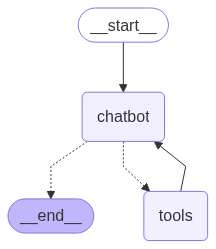

In [117]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### ⭐️ Executing the Emergency Response Agent

In [121]:
import asyncio
import time

from langchain_core.messages import AIMessage, HumanMessage


async def chat_loop():
    config = {"configurable": {"thread_id": "001"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(
            None, input, "User: "
        )
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Use a sanitized name for the human
        state = {"messages": [HumanMessage(content=user_input, name="human")]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
            try:
                async for chunk in graph.astream(state, config, stream_mode="values"):
                    if chunk.get("messages"):
                        last_message = chunk["messages"][-1]
                        if isinstance(last_message, AIMessage):
                            # Ensure the AI name is properly sanitized
                            last_message.name = "assistant"
                            print(last_message.content, end="", flush=True)
                        elif isinstance(last_message, ToolMessage):
                            # Sanitize tool names as well
                            tool_name = sanitize_name(last_message.name)
                            print(f"\n[Tool Used: {tool_name}]")
                            print(f"Tool Call ID: {last_message.tool_call_id}")
                            print(f"Content: {last_message.content}")
                            print("Assistant: ", end="", flush=True)
                break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"\nAn unexpected error occurred: {e!s}")
                    print(f"\nRetrying in {retry_delay} seconds...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2
                else:
                    print(f"\nMax retries reached. Error: {e!s}")
                    break

        print("\n")  # New line after the complete response

In [122]:
# For Jupyter notebooks and IPython environments
import nest_asyncio

nest_asyncio.apply()

# Run the async function
await chat_loop()

Assistant: 

/var/folders/tw/h5zv0cns7yg3z_ytt6y14d3m0000gn/T/ipykernel_22167/3852964.py:22: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name="assistant")


Crisis event saved into records
Crisis Event Generated:
{
  "event_id": "CRISIS-20250505-001",
  "event_type": "Network Outage",
  "severity": "critical",
  "title": "Critical 5G Network Outage Across Major US Cities",
  "description": "A complete failure of the 5G network service has impacted North America, affecting core network elements and gNodeB stations, due to equipment overheating during a maintenance window. Primary data center hardware failures confirmed. Outage confirmed as business-critical with significant revenue and SLA impacts, and heightened media attention.",
  "affected_systems": [
    "5G Network Service",
    "Core Network",
    "gNodeB Stations",
    "Primary Data Center"
  ],
  "affected_regions": [
    "New York City metro area",
    "Boston metropolitan region",
    "Philadelphia and surrounding counties",
    "North America (wider impact reported)"
  ],
  "customer_impact": "Estimated 2 million customers unable to access 5G services; degraded data speeds to 4G

/var/folders/tw/h5zv0cns7yg3z_ytt6y14d3m0000gn/T/ipykernel_22167/3852964.py:22: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name="assistant")




Assistant: 

/var/folders/tw/h5zv0cns7yg3z_ytt6y14d3m0000gn/T/ipykernel_22167/3852964.py:22: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name="assistant")



2. Identifying experts with required skills:
3. Gathering relevant knowledge assets:

Search Query: Find experts with Network engineering (5G expertise), Hardware repair, Crisis management, Customer communications in their skills and experience


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

- Identified 5 experts with relevant skills
  1. Aisha Patel (Network Engineer)
  2. Sophia Kim (Network Engineer)
  3. Sarah Kim (Network Engineer)
  4. Jordan Singh (Network Engineer)
  5. Ravi Sharma (Network Engineer)
- Retrieved 5 knowledge assets
  1. Best Practices for API Deployment and Version Management (best_practice)
  2. Standard Procedures and Best Practices for Secure API Development (best_practice)
  3. CI/CD Pipeline Setup: Best Practices and Technical Procedures (documentation)
  4. Continuous Integration and Deployment (CI/CD) Pipeline Best Practices (best_practice)
  5. Automated Deployment Pipeline: Procedures and Best Practices (best_practice)

[Tool Used: gather_knowledge]
Tool Call ID: call_rej8xvdmNXOFtQCj0zS5JVzH
Content: [{"asset_id": "knowledge_assets-3", "title": "Best Practices for API Deployment and Version Management", "type": "best_practice", "author": "employees-6", "content": "", "creation_date": "2024-06-18", "relevance_score": 0.7269736528396606}, {

/var/folders/tw/h5zv0cns7yg3z_ytt6y14d3m0000gn/T/ipykernel_22167/3852964.py:22: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name="assistant")




Goodbye!


In [ ]:
"""
  NETWORK CRISIS REPORT - PRIORITY CRITICAL

  Incident #: INC-20250505-3547
  Service: 5G Network Service
  Status: ACTIVE OUTAGE

  SUMMARY:
  Complete 5G network failure reported across North America region

  AFFECTED AREAS:
  - New York City metro area
  - Boston metropolitan region
  - Philadelphia and surrounding counties

  IMPACT ASSESSMENT:
  - Estimated 2 million customers unable to access 5G services
  - Enterprise customers reporting business-critical service disruptions
  - Mobile data speeds degraded to 4G in surrounding areas

  TECHNICAL DETAILS:
  - Core Network Status: DOWN
  - gNodeB Stations: 3/5 nodes failed
  - Data Center: Primary facility shows hardware failures
  - Root Cause: Equipment overheating during maintenance window

  TIMELINE:
  15:00 EST - Maintenance window begins
  15:25 EST - First customer complaints received
  15:30 EST - Network monitoring alerts triggered
  15:45 EST - Service outage confirmed

  REQUIRED RESPONSE:
  - Network engineers with 5G expertise
  - Hardware repair technicians
  - Crisis management team
  - Customer communications team

  BUSINESS IMPACT:
  - Revenue impact: $5,000/minute
  - SLA breach: Yes (2-hour response requirement)
  - Media attention: High (local news coverage)

  NEXT STEPS:
  1. Activate emergency response protocol
  2. Dispatch on-site technicians
  3. Prepare customer communications
  4. Assess backup systems deployment
"""